In [5]:
"""
Particle Filter localization sample
author: Atsushi Sakai (@Atsushi_twi)
"""

import numpy as np
import math
import matplotlib.pyplot as plt

# Estimation parameter of PF
Q = np.diag([0.1])**2  # range error
R = np.diag([1.0, math.radians(40.0)])**2  # input error

#  Simulation parameter
Qsim = np.diag([0.2])**2
Rsim = np.diag([1.0, math.radians(30.0)])**2

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range

# Particle filter parameter
NP = 100  # Number of Particle
NTh = NP / 2.0  # Number of particle for re-sampling

show_animation = True


def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.matrix([v, yawrate]).T
    return u


def observation(xTrue, xd, u, RFID):

    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = np.matrix(np.zeros((0, 3)))

    for i in range(len(RFID[:, 0])):

        dx = xTrue[0, 0] - RFID[i, 0]
        dy = xTrue[1, 0] - RFID[i, 1]
        d = math.sqrt(dx**2 + dy**2)
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            zi = np.matrix([dn, RFID[i, 0], RFID[i, 1]])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
    ud = np.matrix([ud1, ud2]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud


def motion_model(x, u):

    F = np.matrix([[1.0, 0, 0, 0],
                   [0, 1.0, 0, 0],
                   [0, 0, 1.0, 0],
                   [0, 0, 0, 0]])

    B = np.matrix([[DT * math.cos(x[2, 0]), 0],
                   [DT * math.sin(x[2, 0]), 0],
                   [0.0, DT],
                   [1.0, 0.0]])

    x = F * x + B * u

    return x


def gauss_likelihood(x, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma ** 2) * \
        math.exp(-x ** 2 / (2 * sigma ** 2))

    return p


def calc_covariance(xEst, px, pw):
    cov = np.matrix(np.zeros((3, 3)))

    for i in range(px.shape[1]):
        dx = (px[:, i] - xEst)[0:3]
        cov += pw[0, i] * dx * dx.T

    return cov


def pf_localization(px, pw, xEst, PEst, z, u):
    """
    Localization with Particle filter
    """

    for ip in range(NP):
        x = px[:, ip]
        w = pw[0, ip]

        #  Predict with ramdom input sampling
        ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
        ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
        ud = np.matrix([ud1, ud2]).T
        x = motion_model(x, ud)

        #  Calc Inportance Weight
        for i in range(len(z[:, 0])):
            dx = x[0, 0] - z[i, 1]
            dy = x[1, 0] - z[i, 2]
            prez = math.sqrt(dx**2 + dy**2)
            dz = prez - z[i, 0]
            w = w * gauss_likelihood(dz, math.sqrt(Q[0, 0]))

        px[:, ip] = x
        pw[0, ip] = w

    pw = pw / pw.sum()  # normalize

    xEst = px * pw.T
    PEst = calc_covariance(xEst, px, pw)

    px, pw = resampling(px, pw)

    return xEst, PEst, px, pw


def resampling(px, pw):
    """
    low variance re-sampling
    """

    Neff = 1.0 / (pw * pw.T)[0, 0]  # Effective particle number
    if Neff < NTh:
        wcum = np.cumsum(pw)
        base = np.cumsum(pw * 0.0 + 1 / NP) - 1 / NP
        resampleid = base + np.random.rand(base.shape[1]) / NP

        inds = []
        ind = 0
        for ip in range(NP):
            while resampleid[0, ip] > wcum[0, ind]:
                ind += 1
            inds.append(ind)

        px = px[:, inds]
        pw = np.matrix(np.zeros((1, NP))) + 1.0 / NP  # init weight

    return px, pw


In [7]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)

    #eigval[bigind] or eiqval[smallind] were occassionally negative numbers extremely
    #close to 0 (~10^-20), catch these cases and set the respective variable to 0
    try: a = math.sqrt(eigval[bigind])
    except ValueError: a = 0

    try: b = math.sqrt(eigval[smallind])
    except ValueError: b = 0

    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.matrix([[math.cos(angle), math.sin(angle)],
                   [-math.sin(angle), math.cos(angle)]])
    fx = R * np.matrix([x, y])
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [8]:
def main():
    # print(__file__ + " start!!")

    time = 0.0

    # RFID positions [x, y]
    RFID = np.array([[10.0, 0.0],
                     [10.0, 10.0],
                     [0.0, 15.0],
                     [-5.0, 20.0]])

    # State Vector [x y yaw v]'
    xEst = np.matrix(np.zeros((4, 1)))
    xTrue = np.matrix(np.zeros((4, 1)))
    PEst = np.eye(4)

    px = np.matrix(np.zeros((4, NP)))  # Particle store
    pw = np.matrix(np.zeros((1, NP))) + 1.0 / NP  # Particle weight
    xDR = np.matrix(np.zeros((4, 1)))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

        xEst, PEst, px, pw = pf_localization(px, pw, xEst, PEst, z, ud)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

        if show_animation:
            plt.cla()

            for i in range(len(z[:, 0])):
                plt.plot([xTrue[0, 0], z[i, 1]], [xTrue[1, 0], z[i, 2]], "-k")
            plt.plot(RFID[:, 0], RFID[:, 1], "*k")
            plt.plot(px[0, :], px[1, :], ".r")
            plt.plot(np.array(hxTrue[0, :]).flatten(),
                     np.array(hxTrue[1, :]).flatten(), "-b")
            plt.plot(np.array(hxDR[0, :]).flatten(),
                     np.array(hxDR[1, :]).flatten(), "-k")
            plt.plot(np.array(hxEst[0, :]).flatten(),
                     np.array(hxEst[1, :]).flatten(), "-r")
            plot_covariance_ellipse(xEst, PEst)
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)


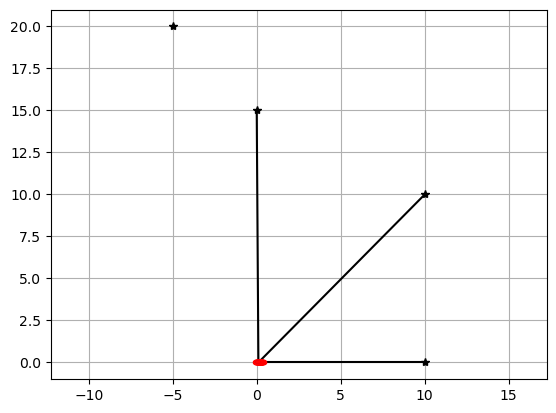

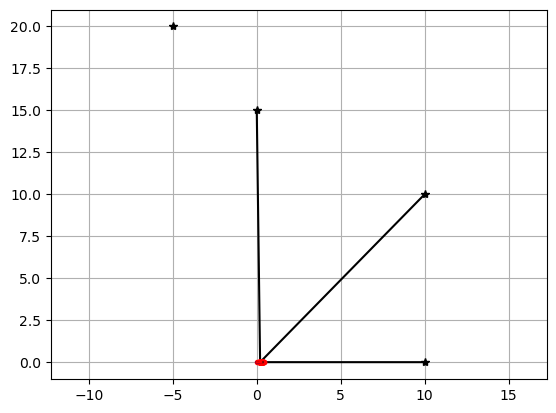

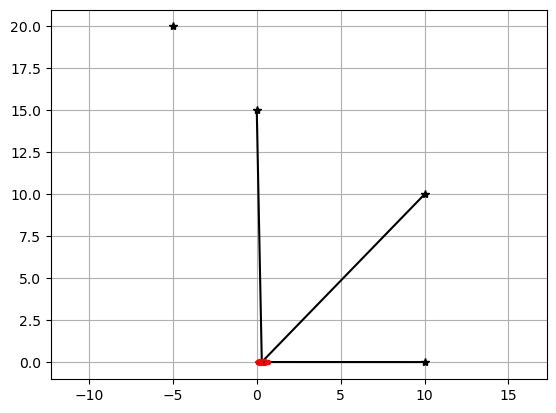

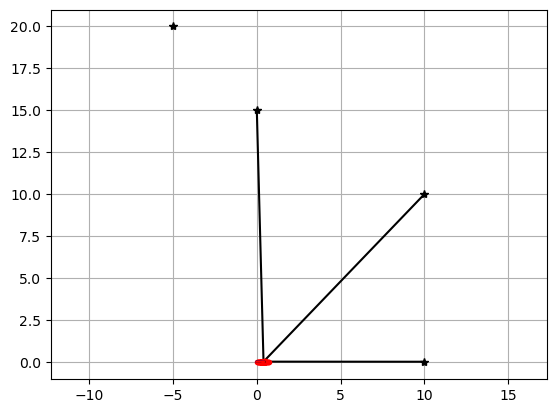

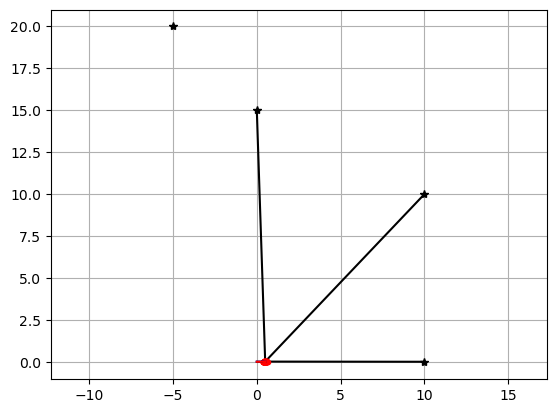

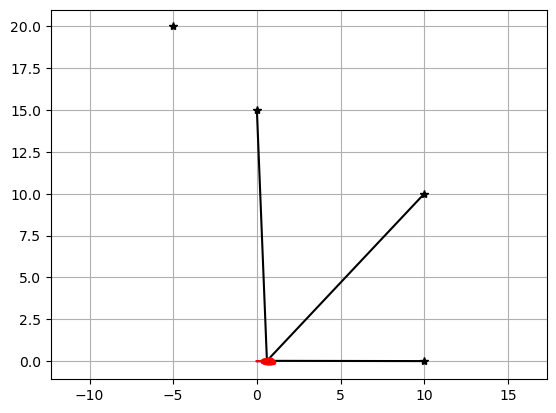

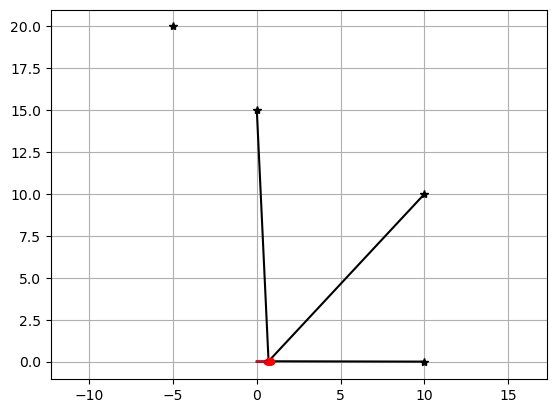

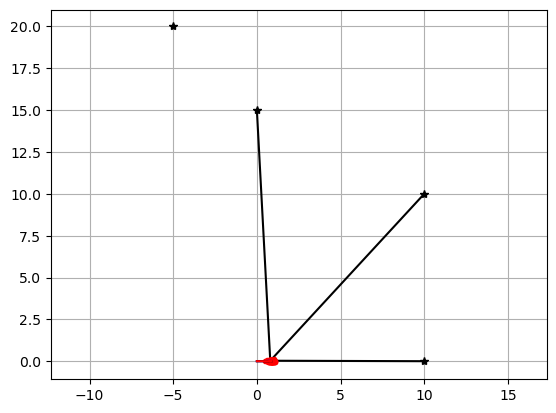

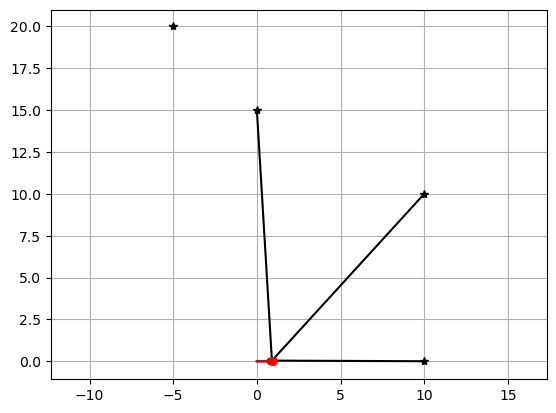

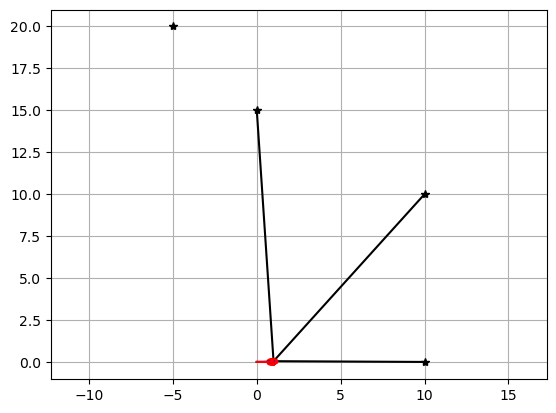

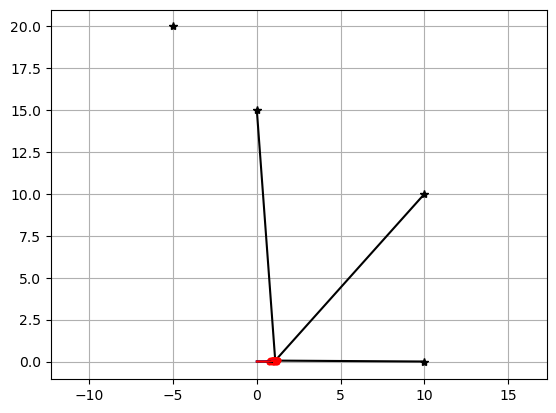

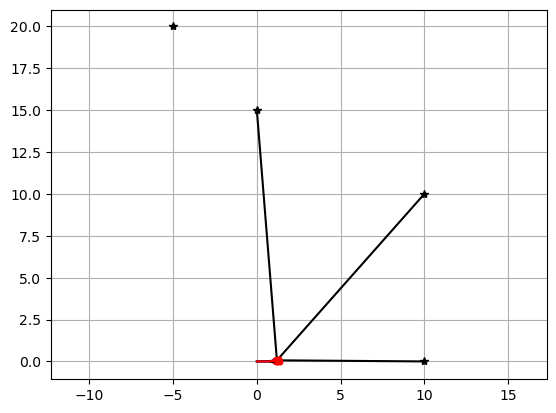

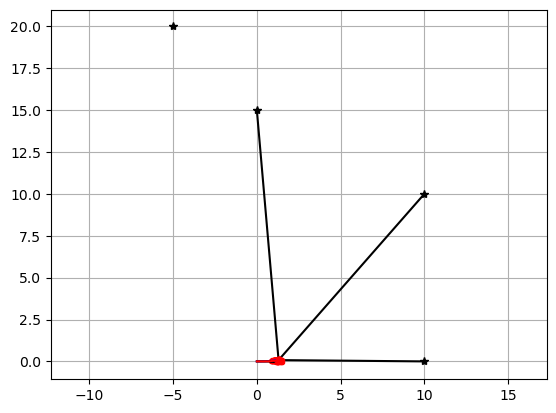

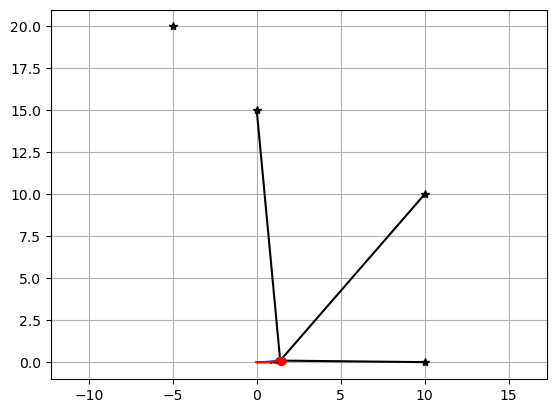

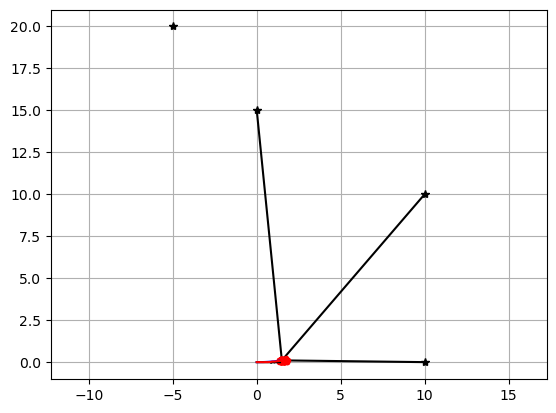

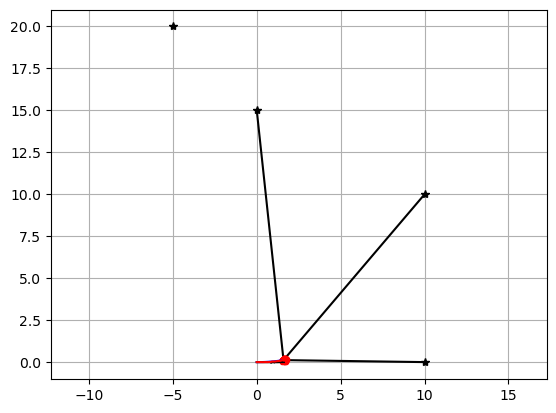

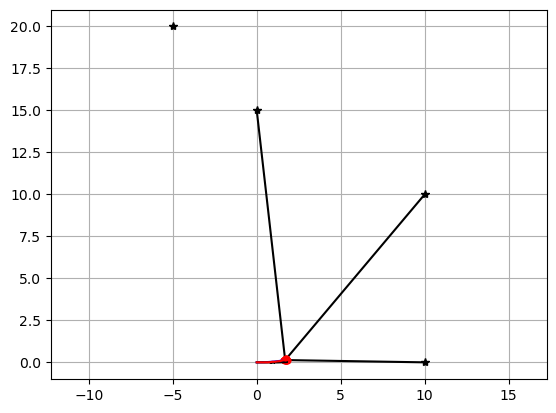

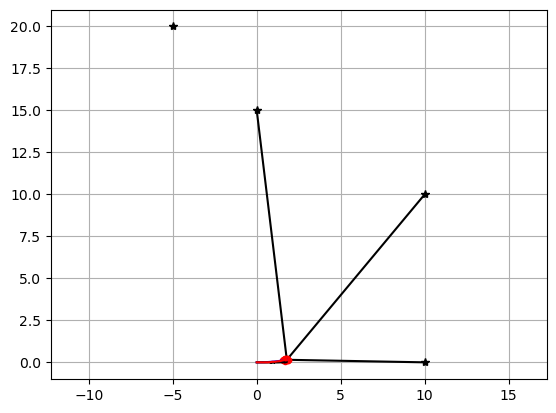

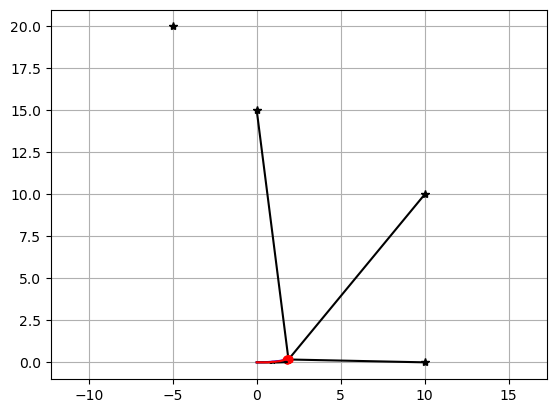

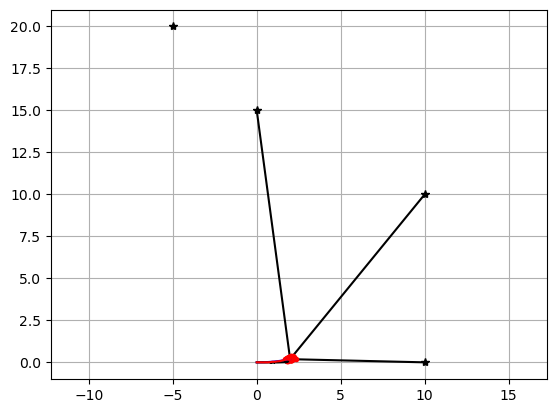

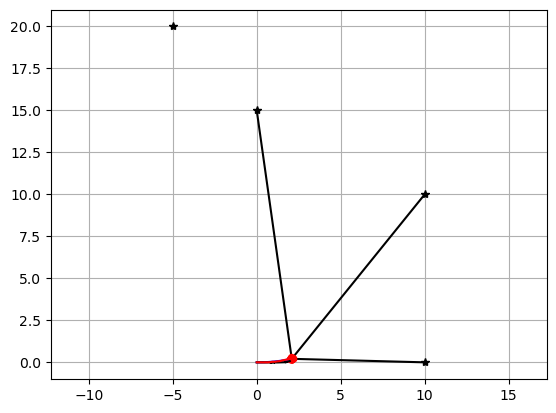

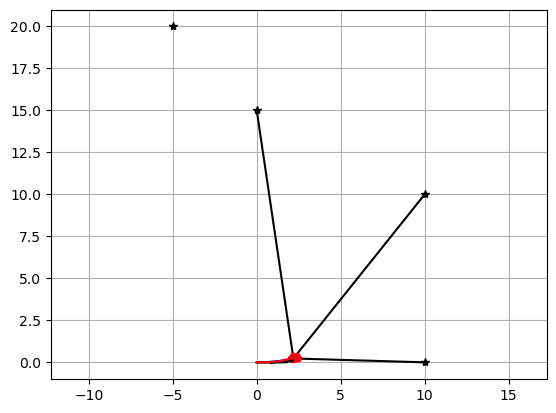

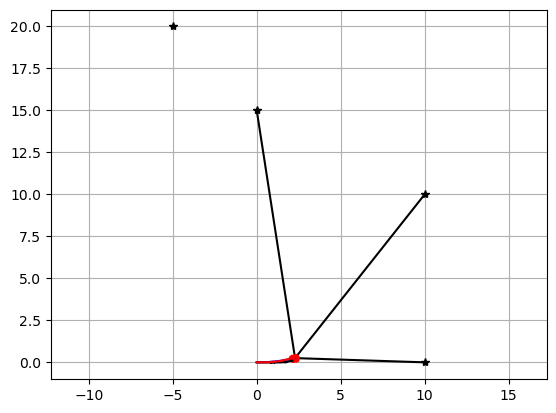

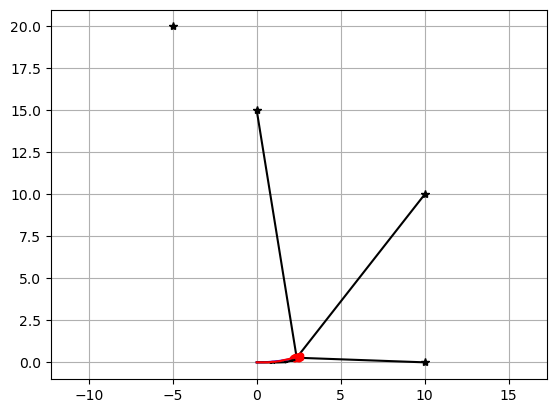

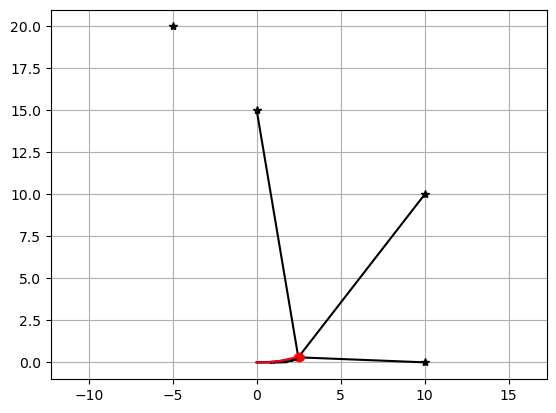

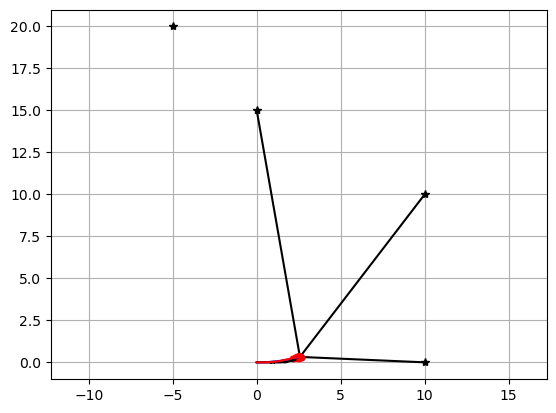

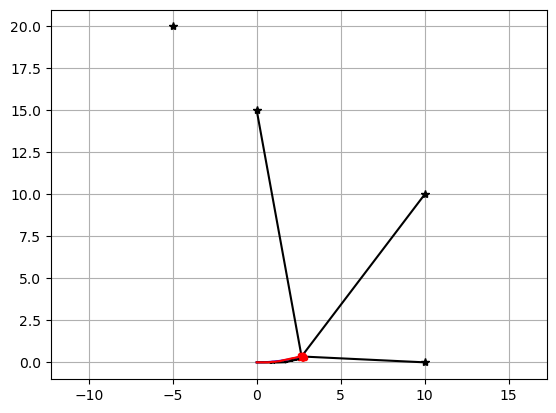

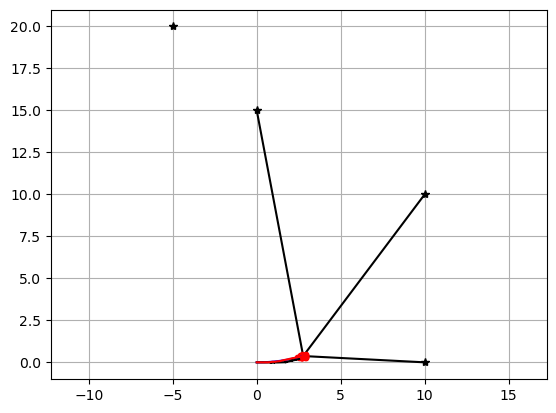

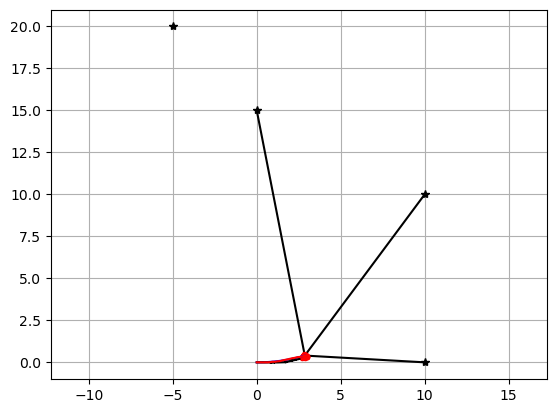

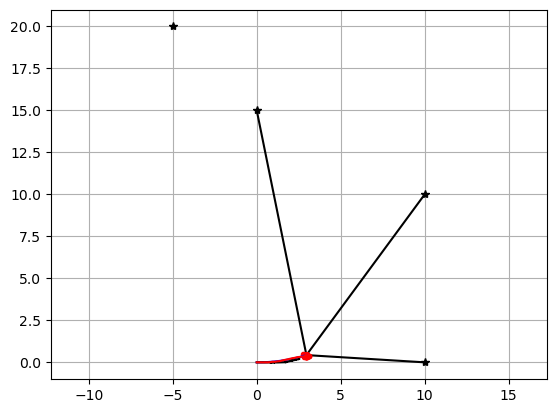

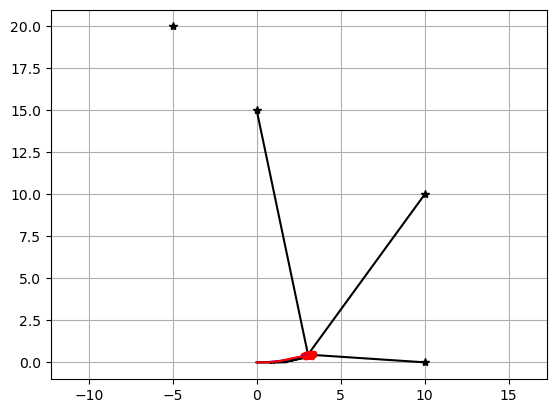

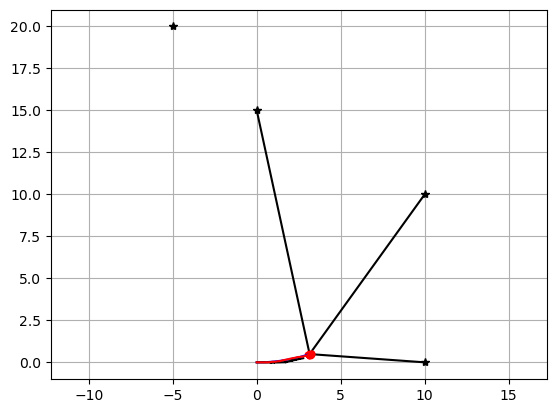

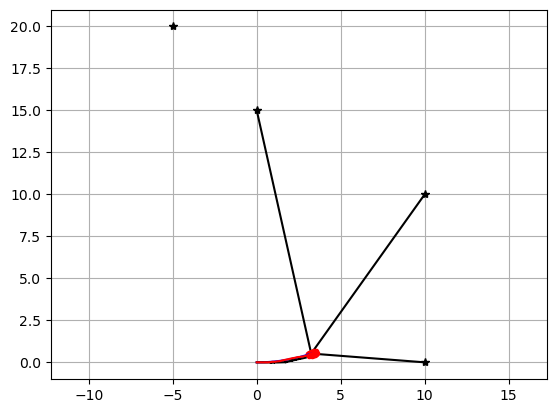

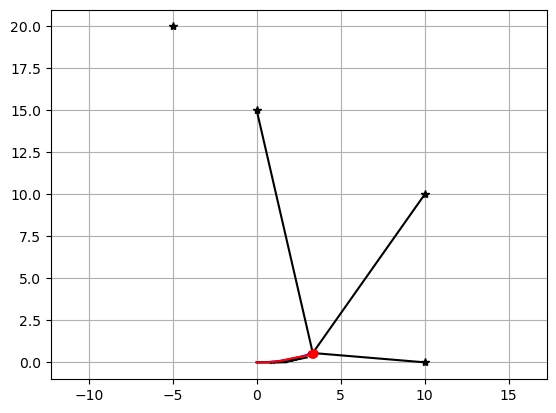

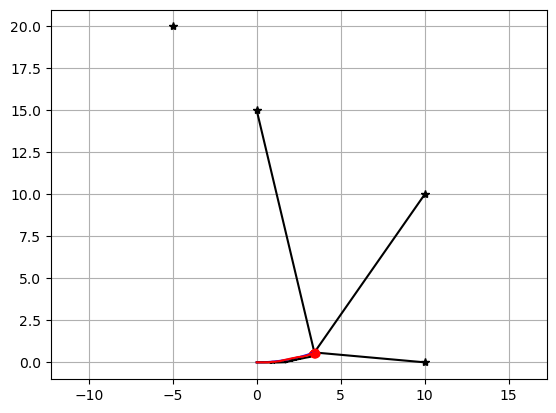

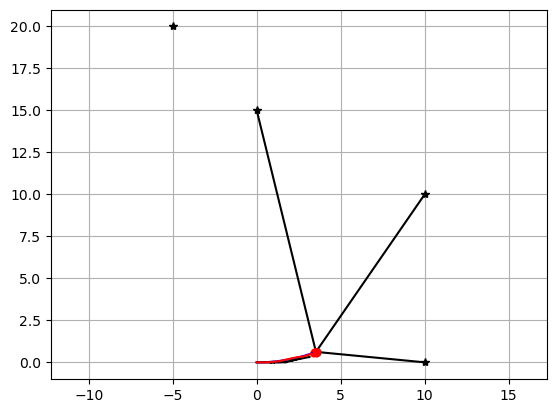

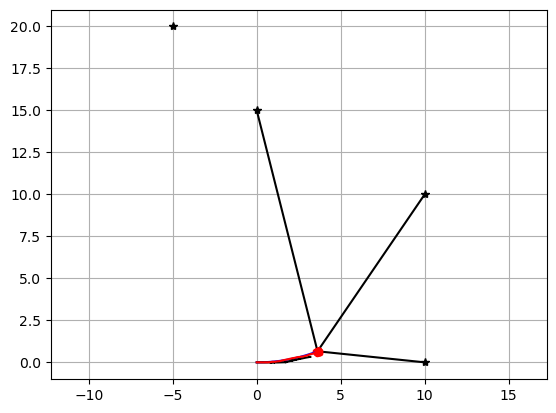

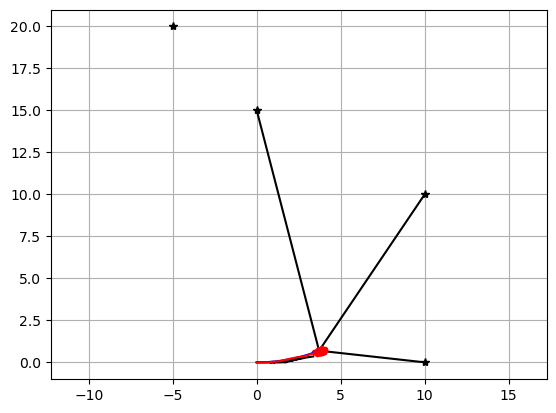

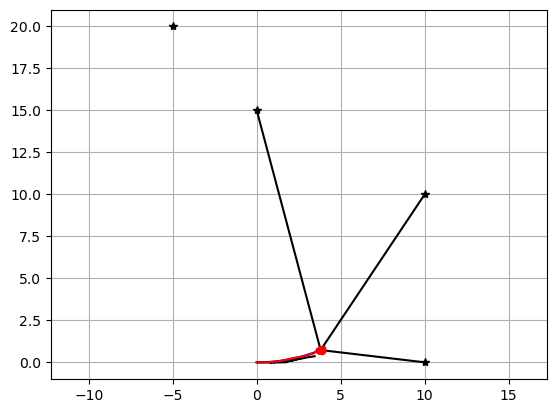

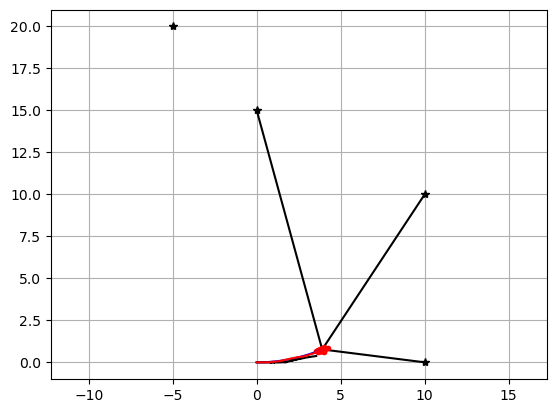

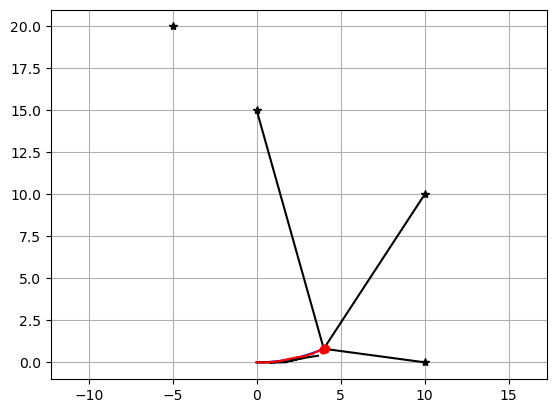

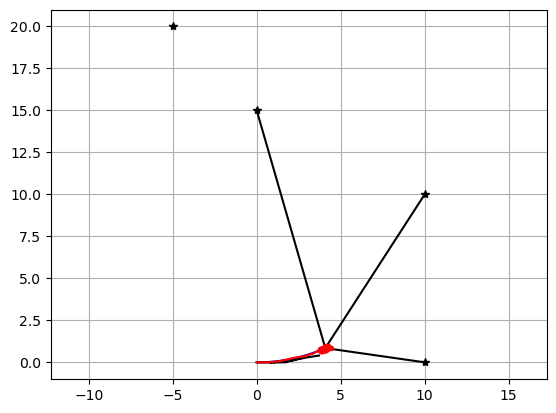

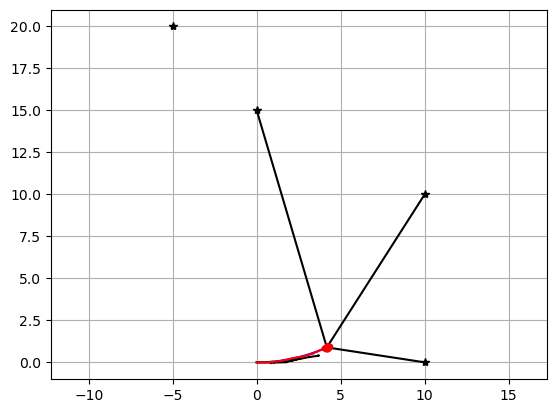

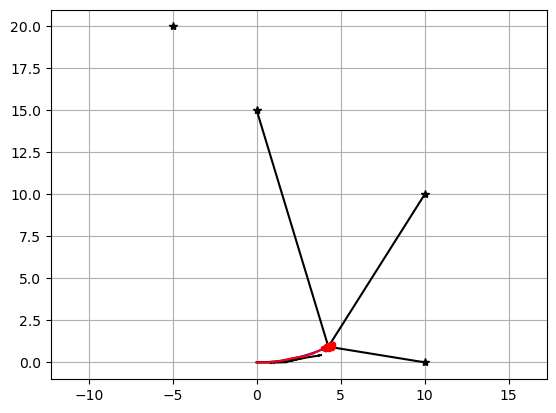

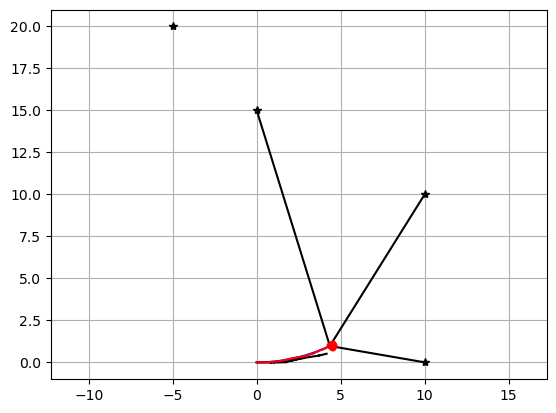

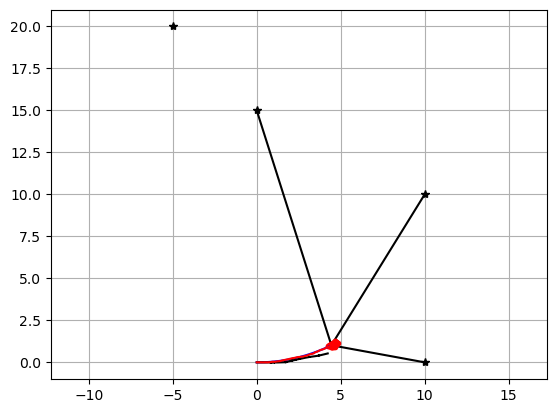

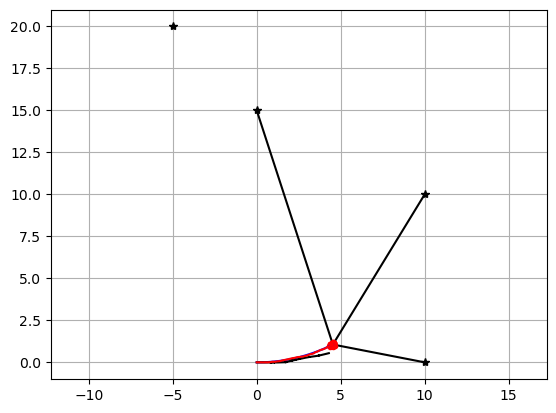

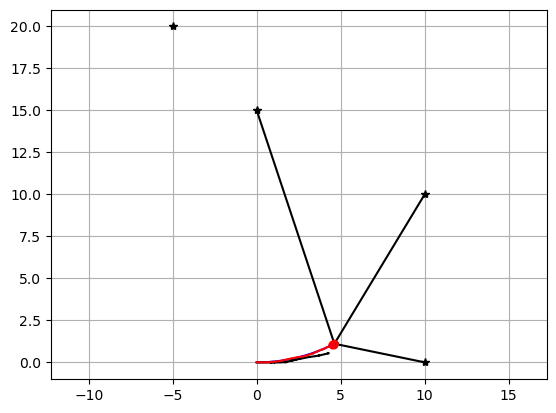

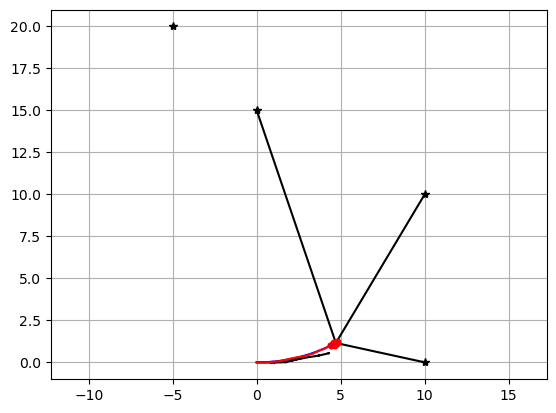

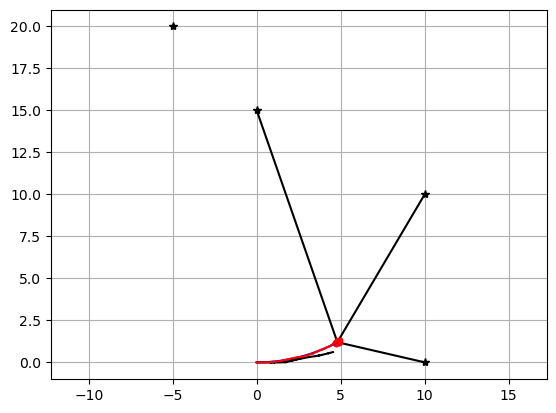

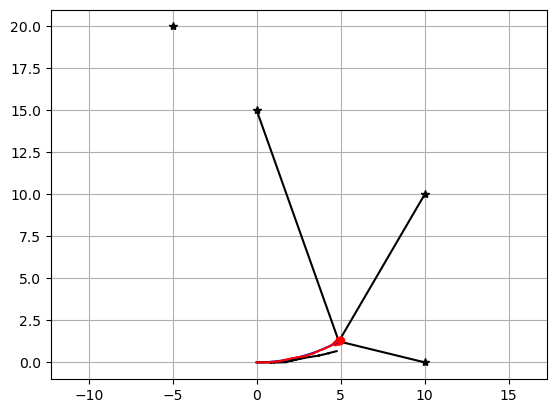

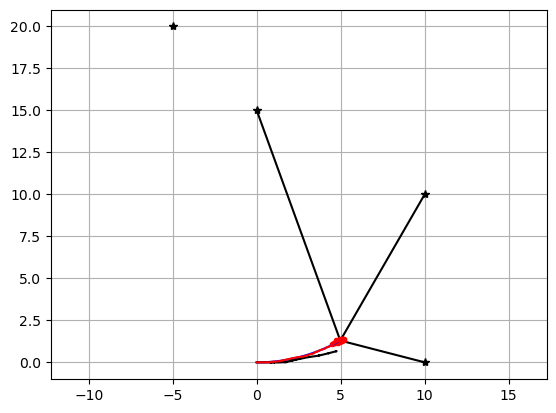

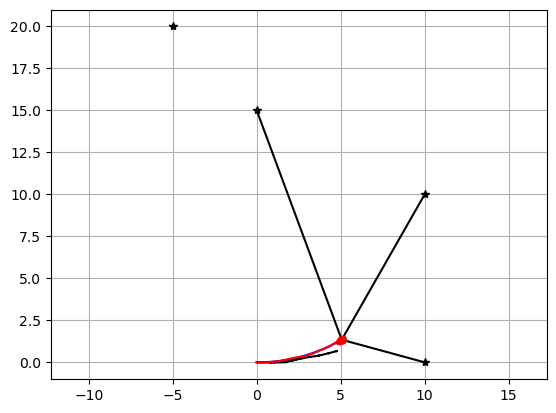

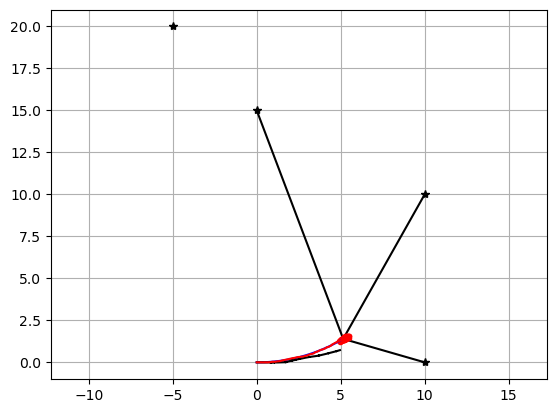

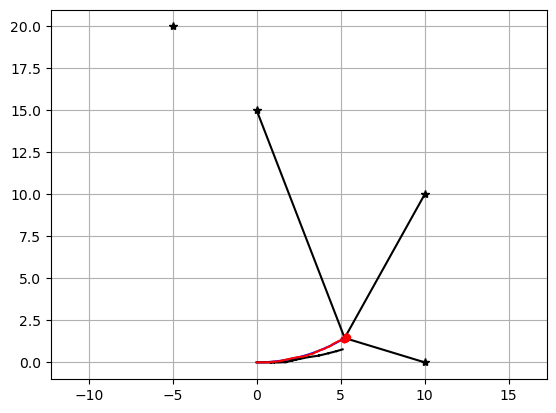

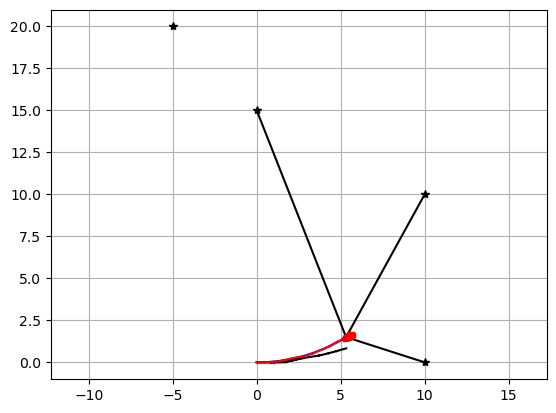

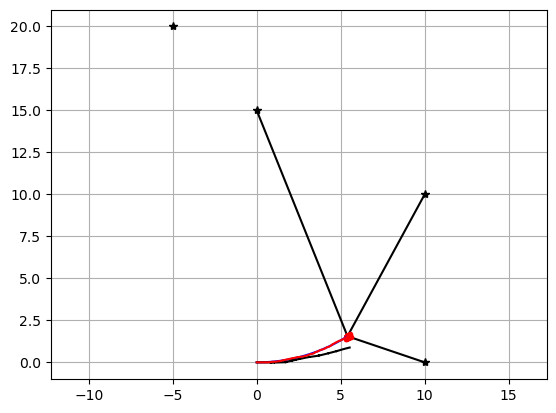

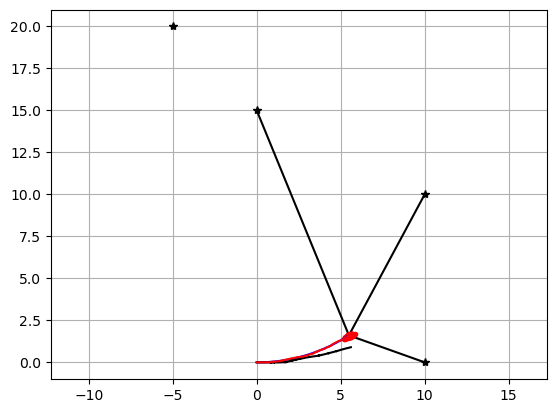

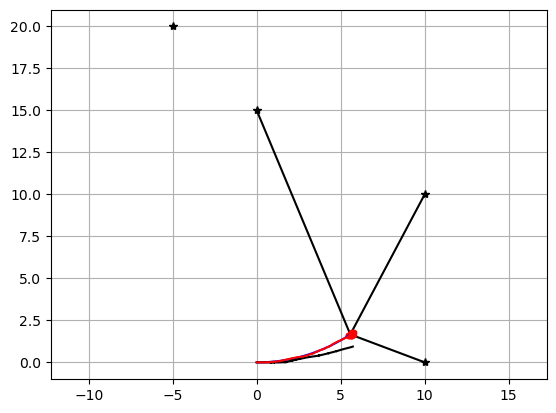

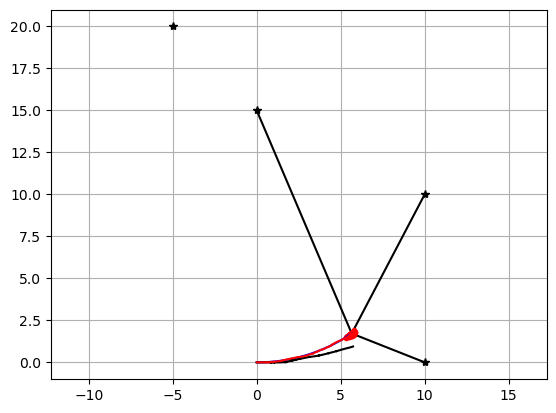

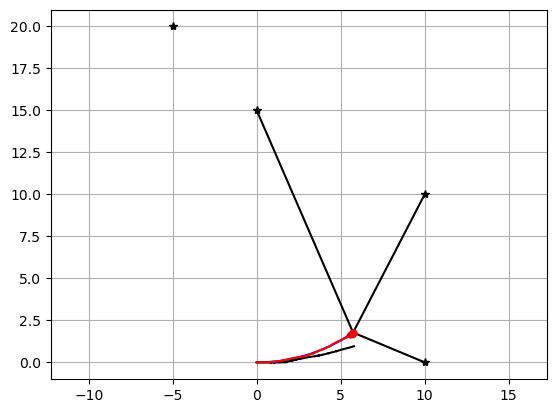

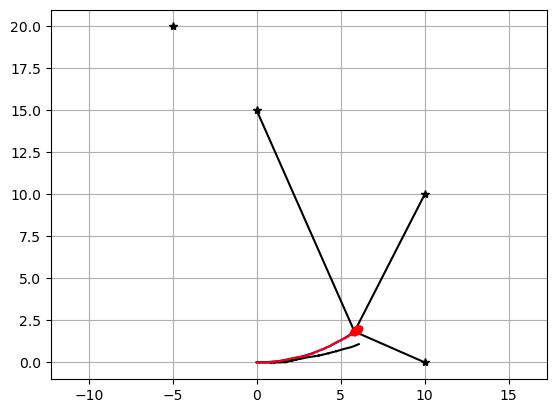

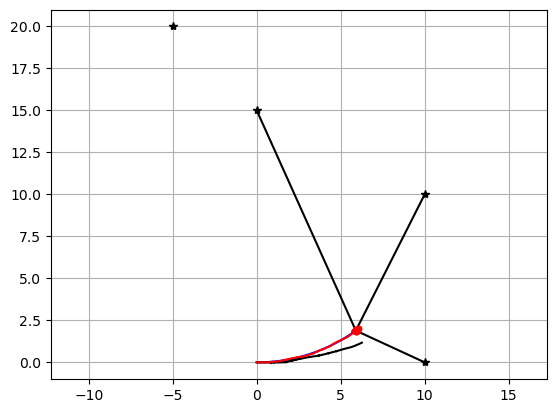

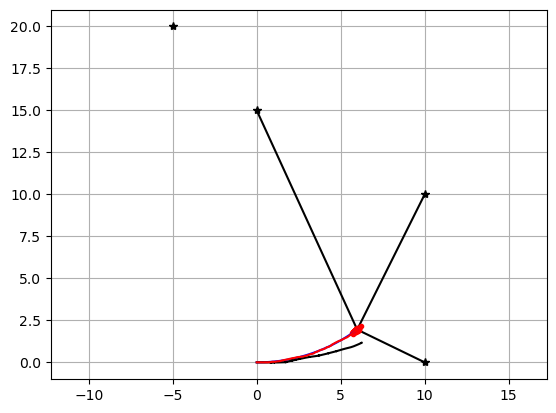

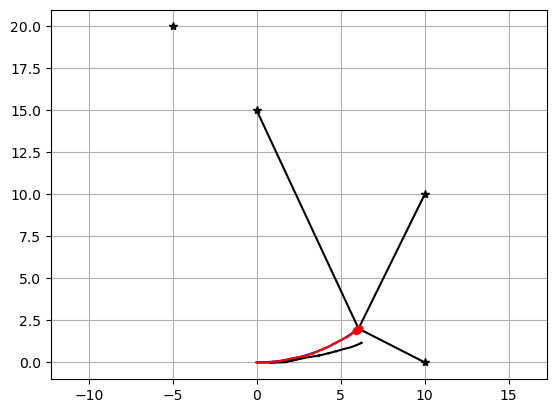

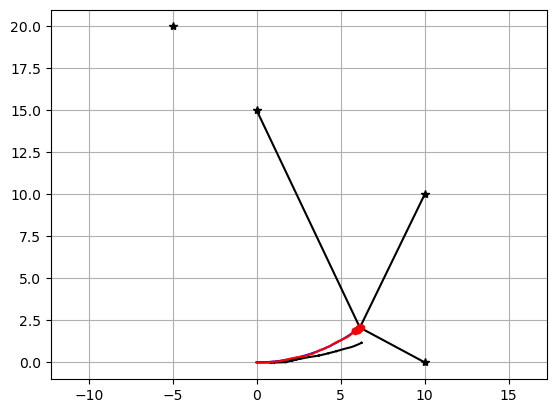

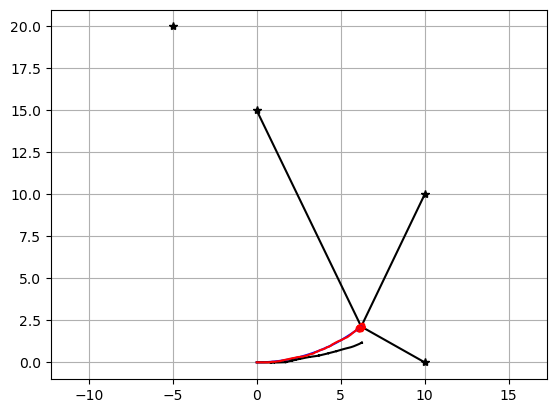

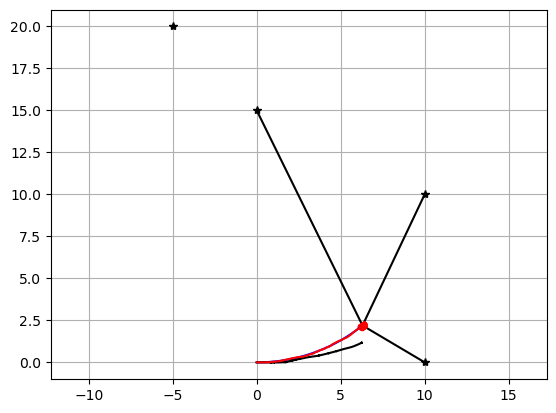

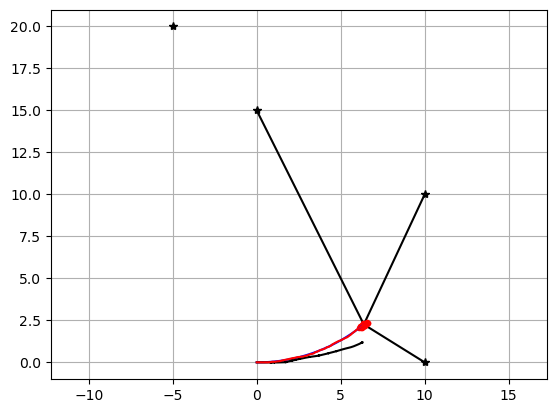

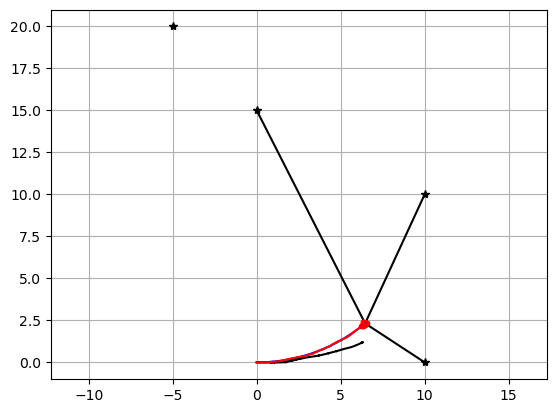

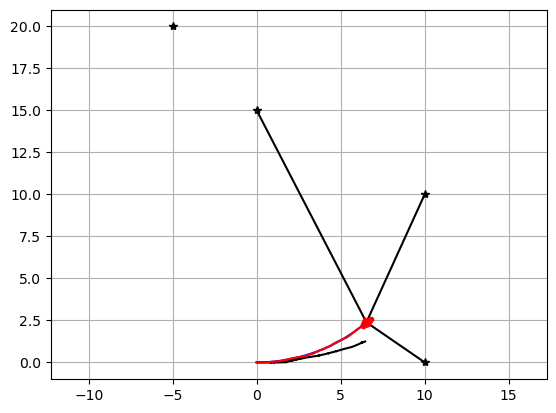

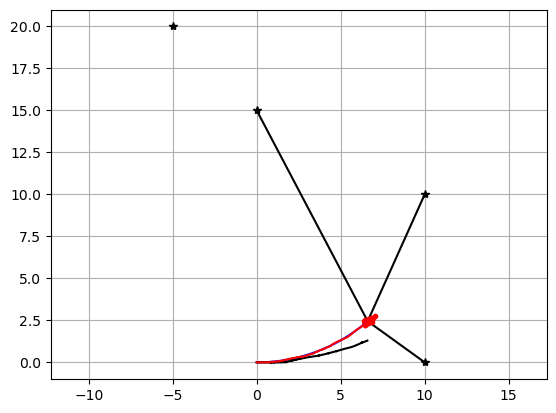

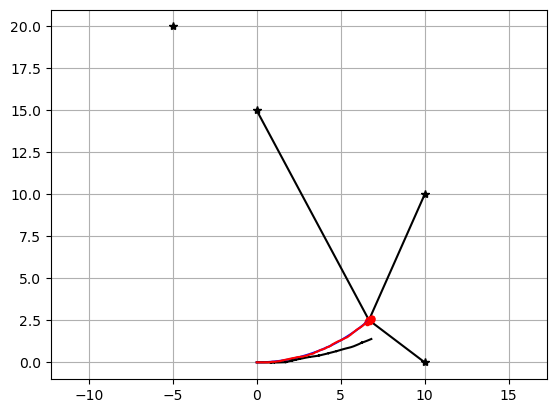

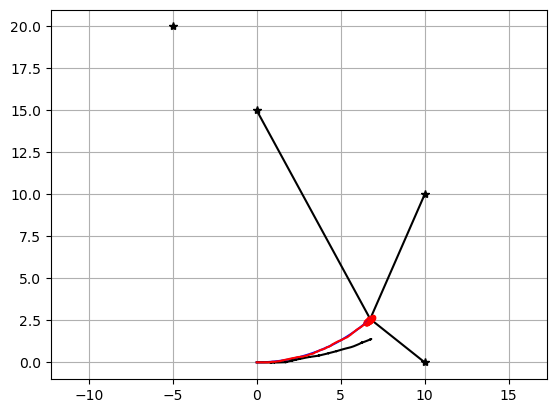

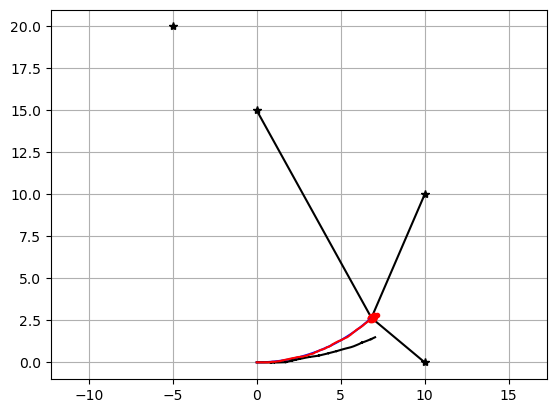

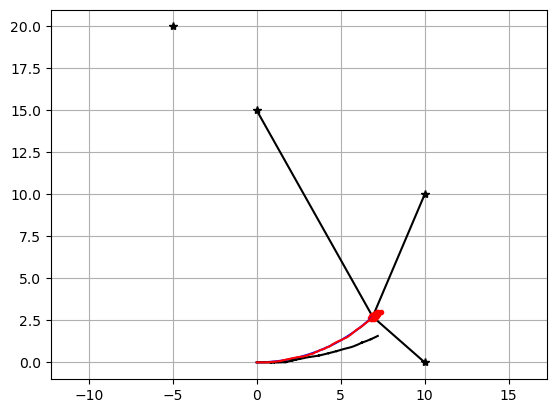

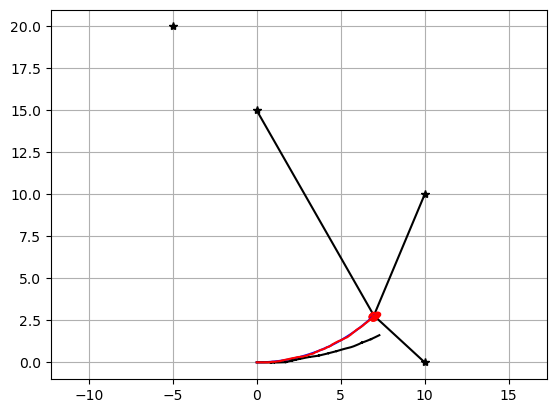

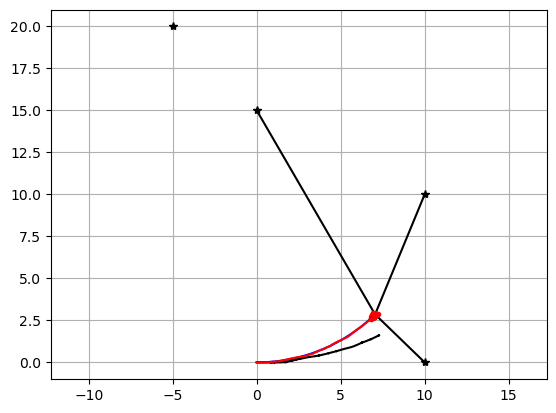

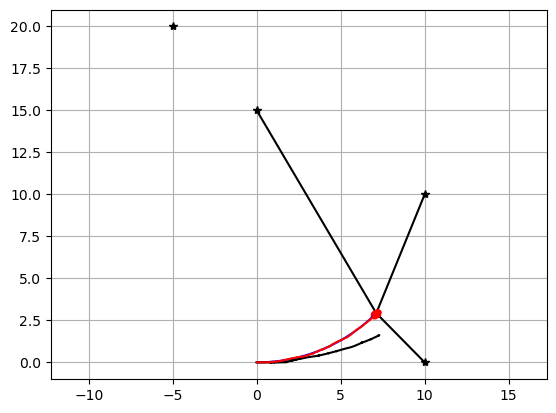

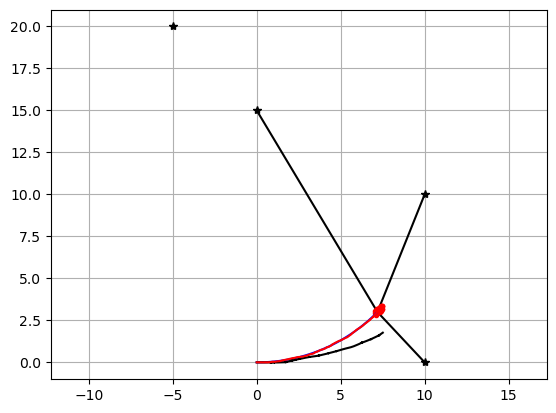

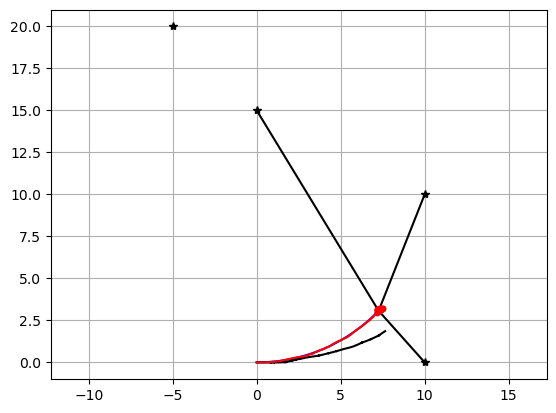

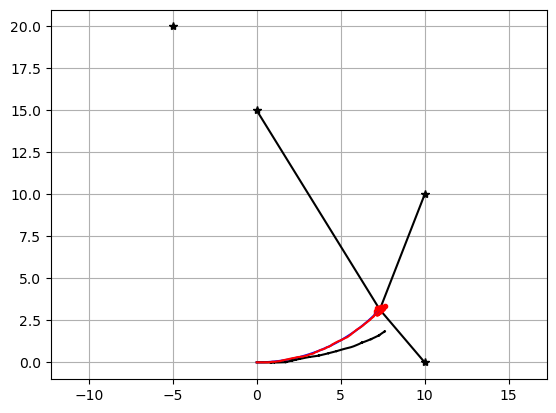

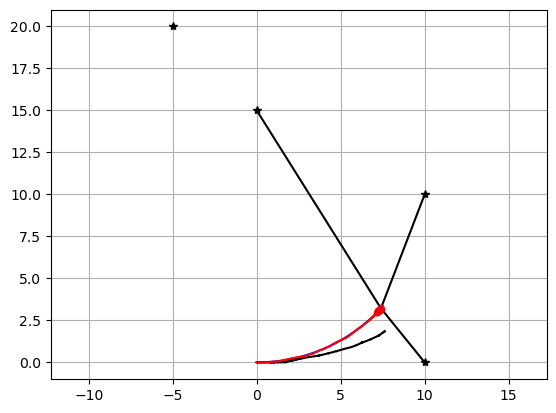

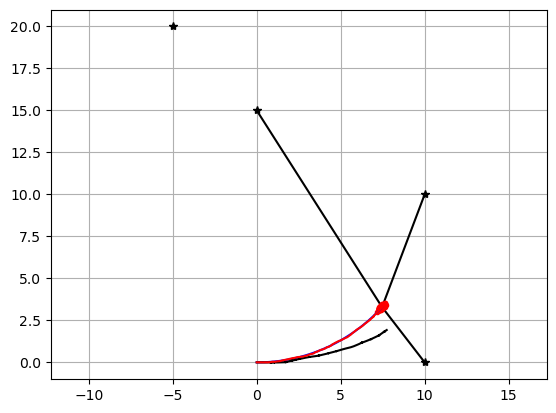

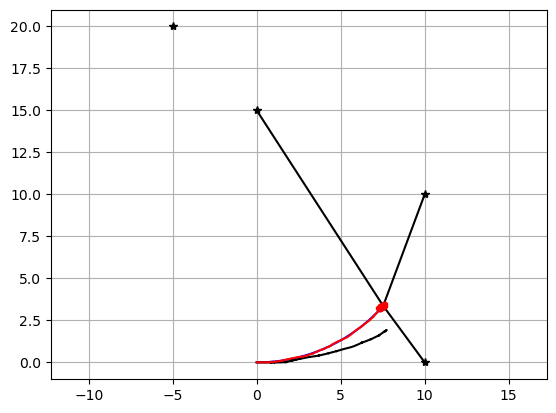

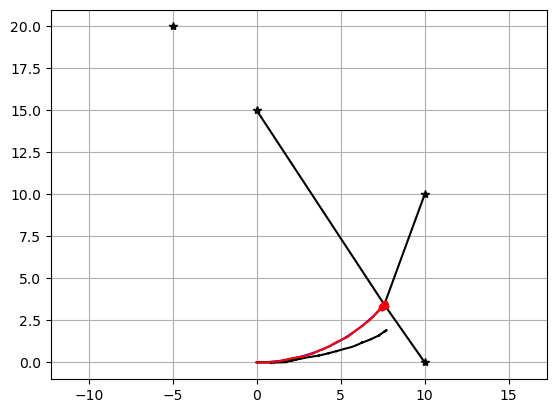

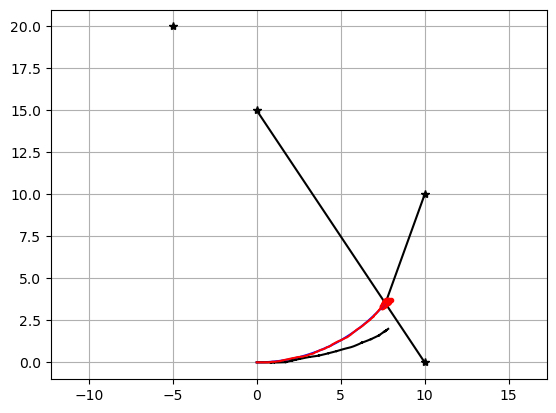

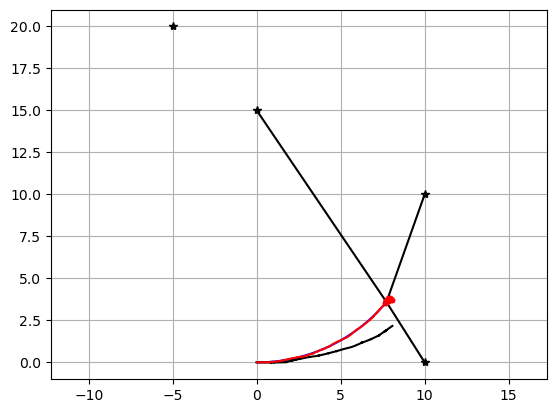

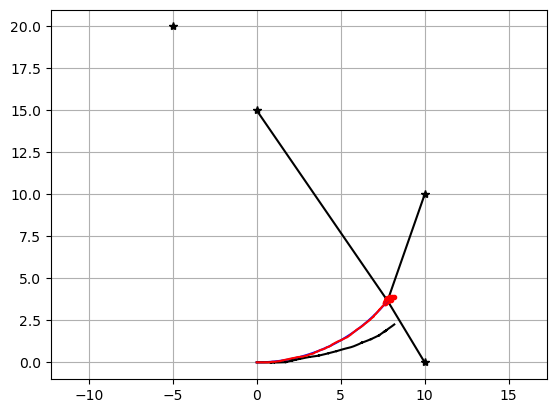

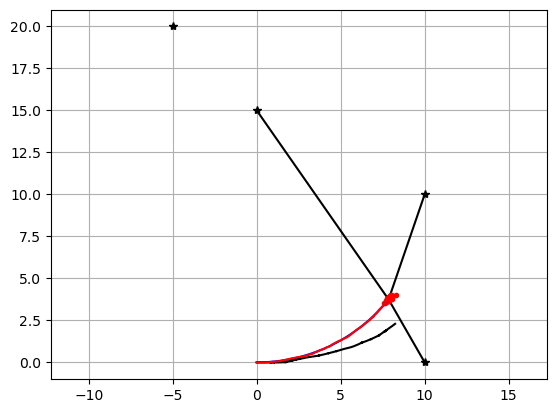

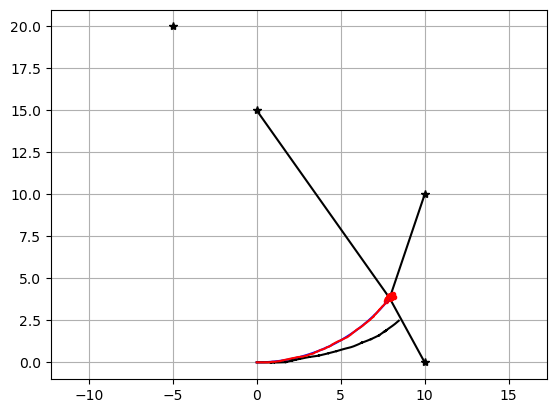

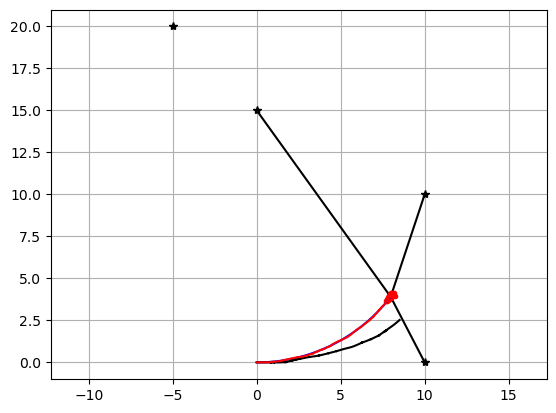

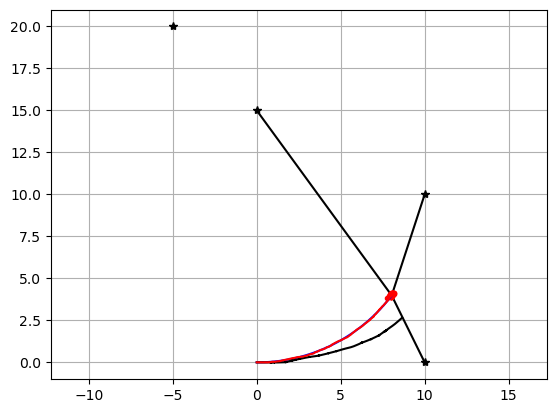

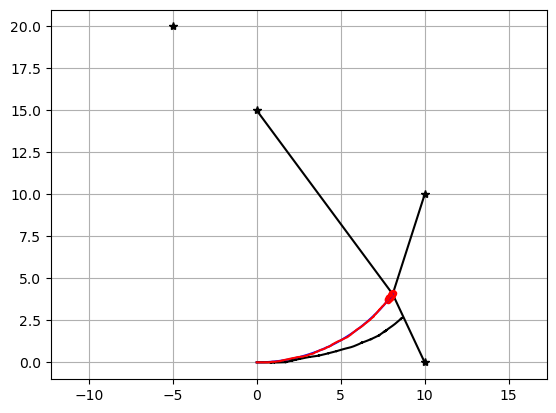

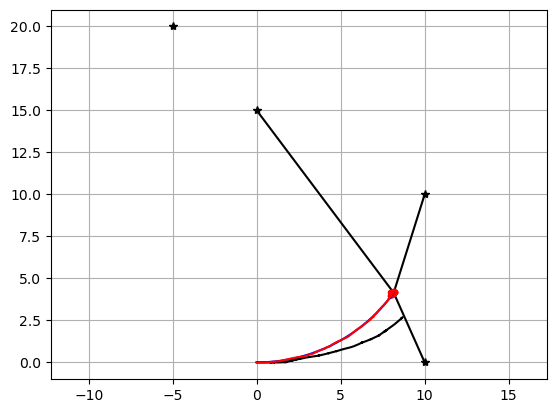

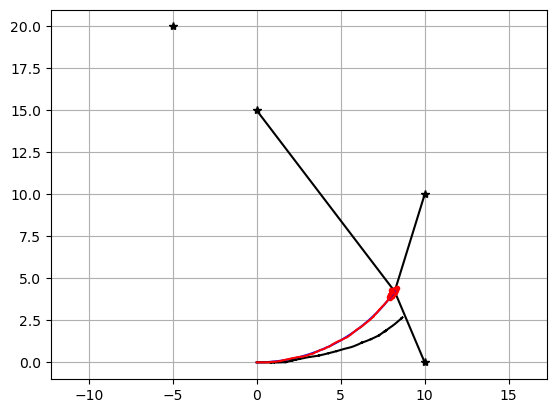

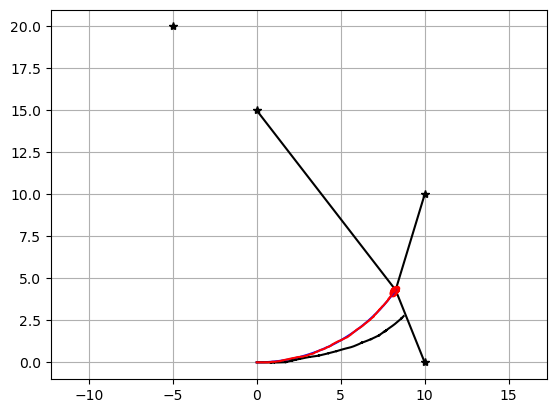

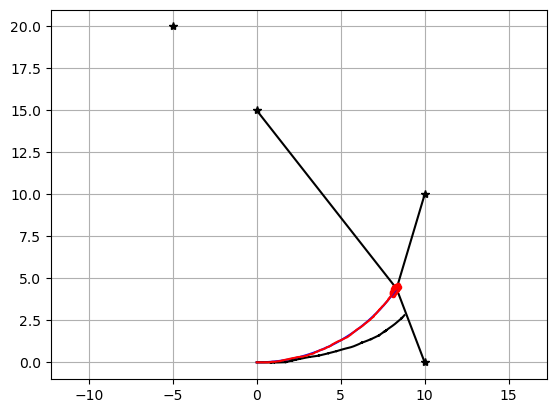

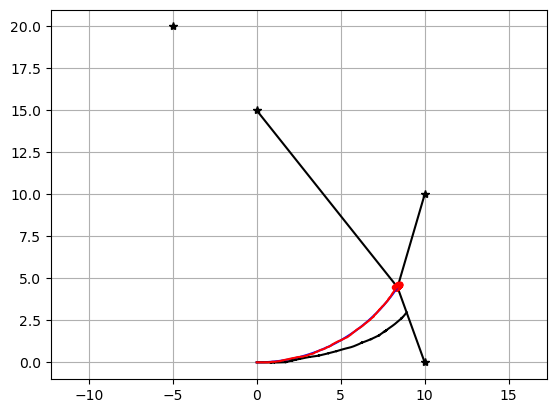

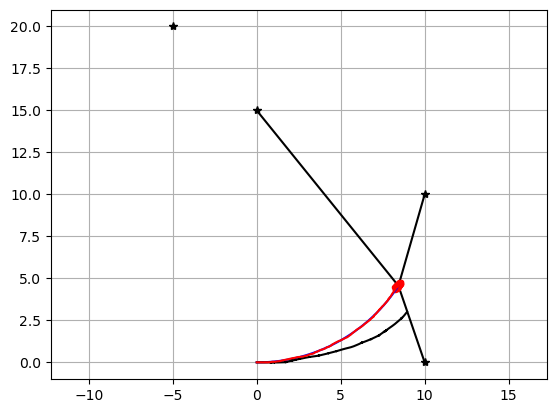

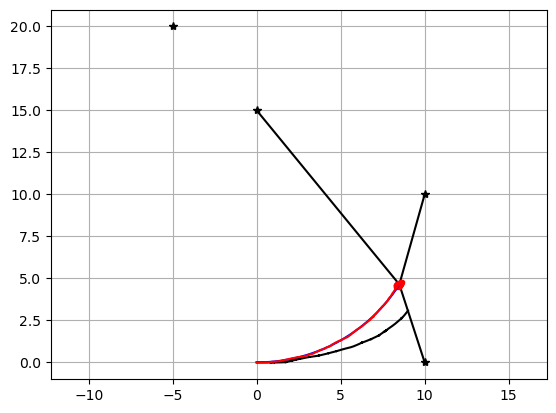

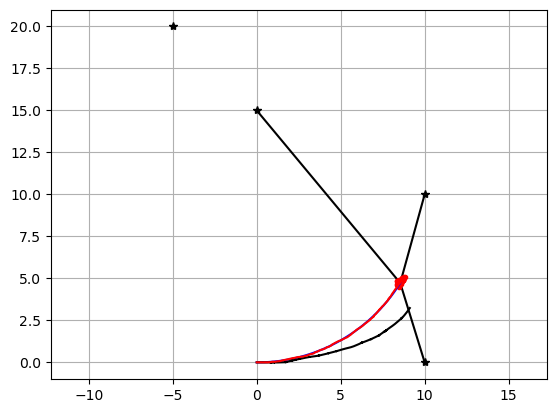

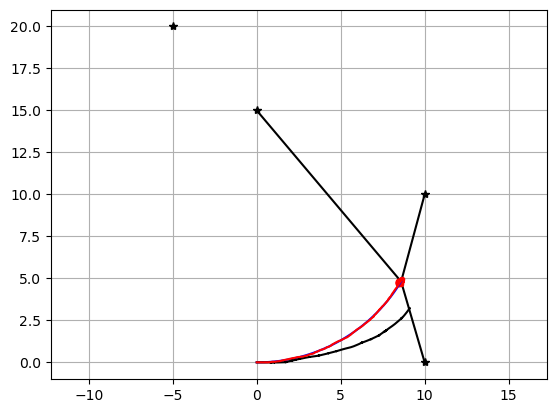

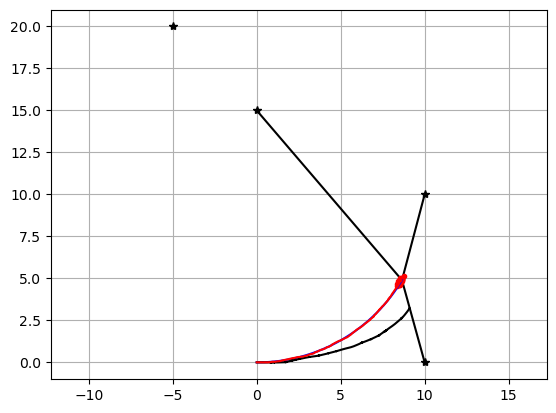

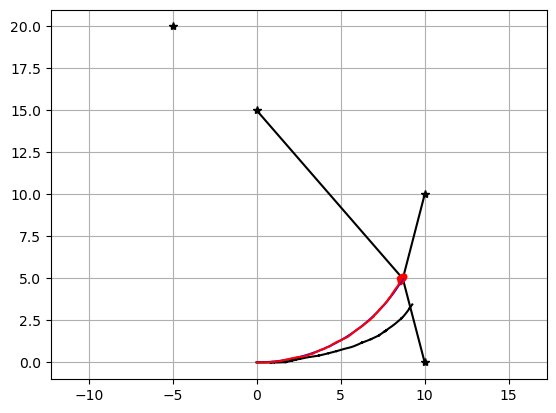

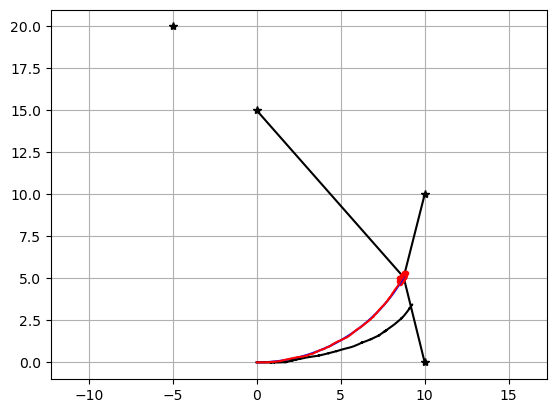

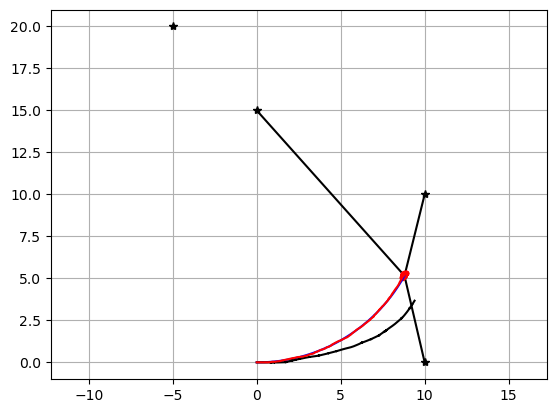

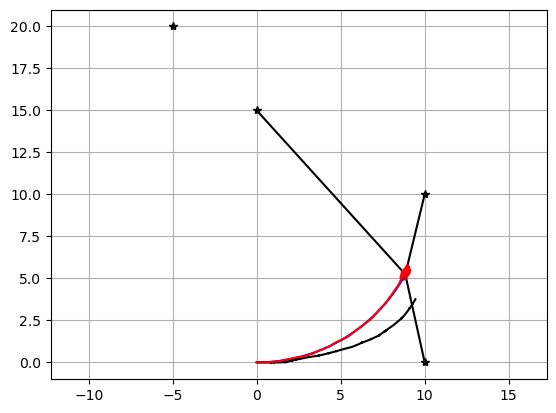

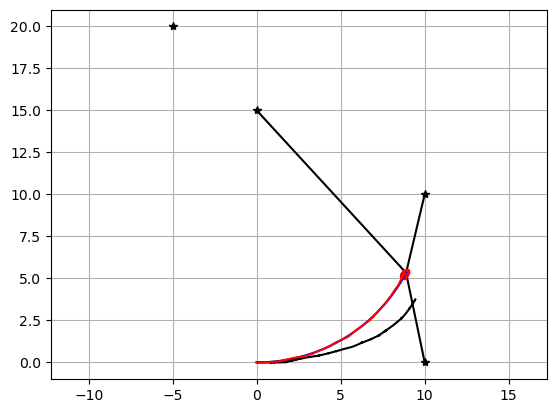

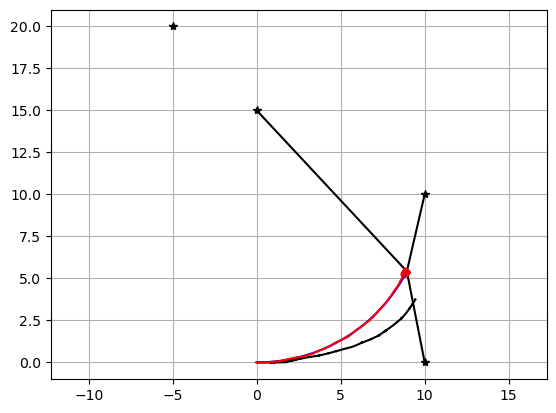

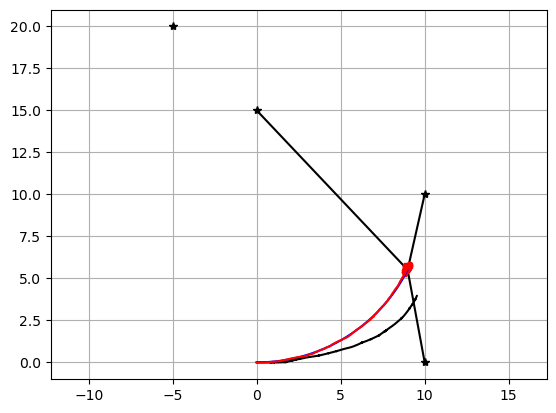

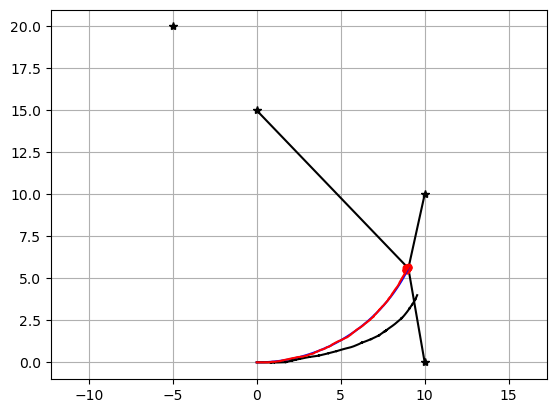

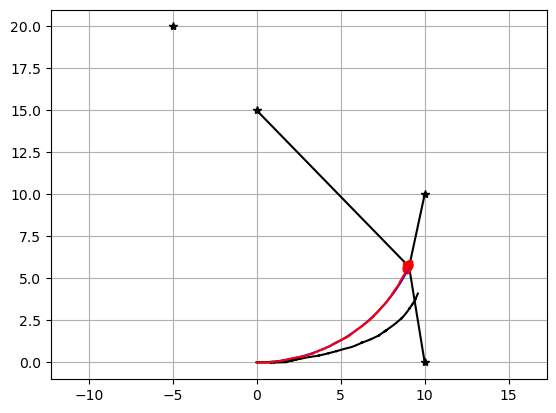

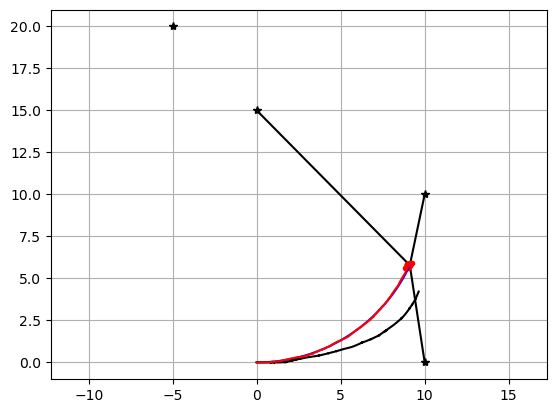

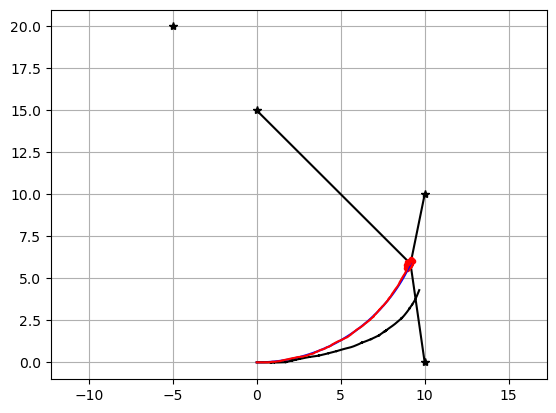

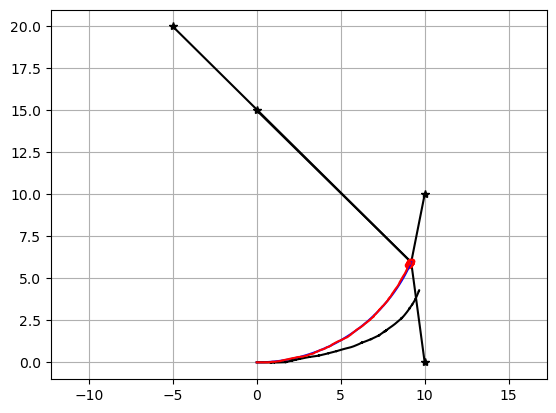

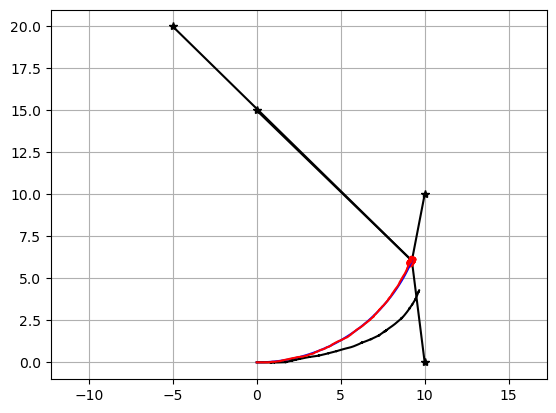

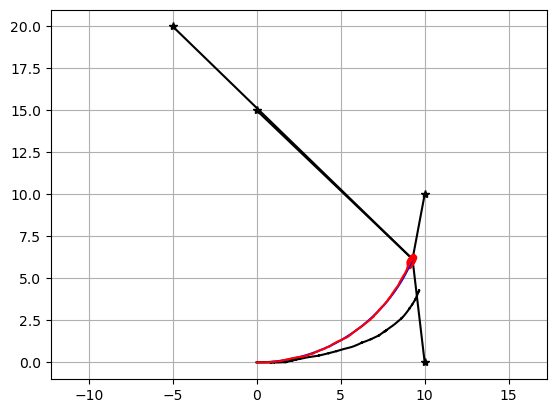

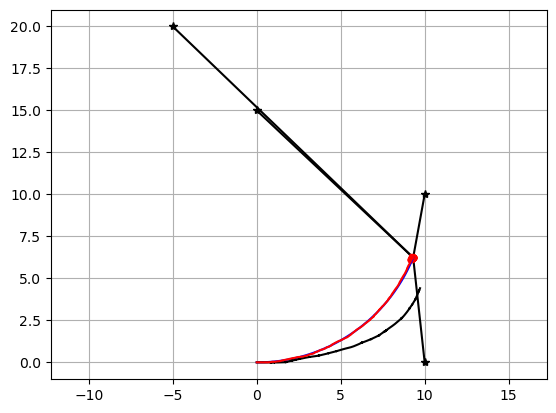

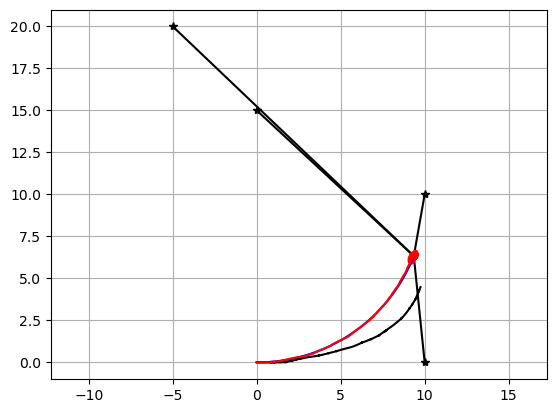

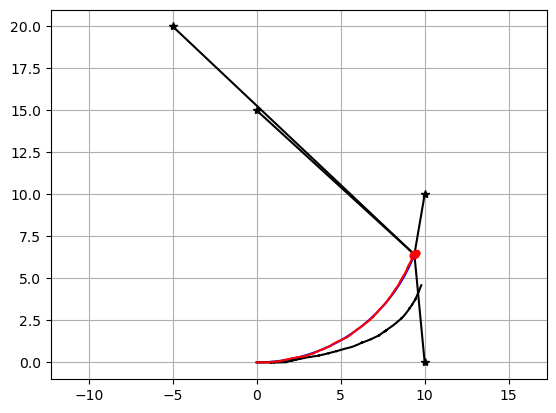

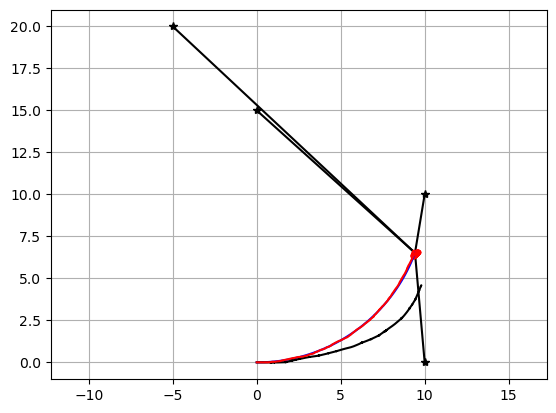

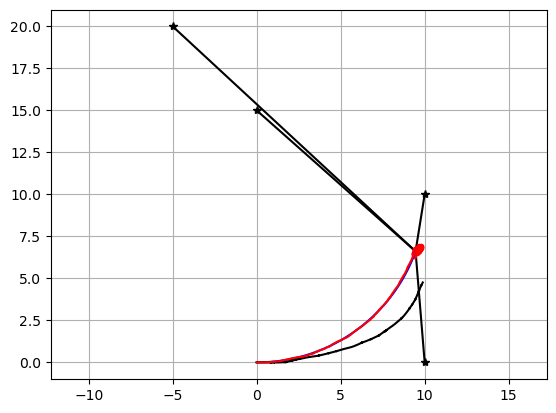

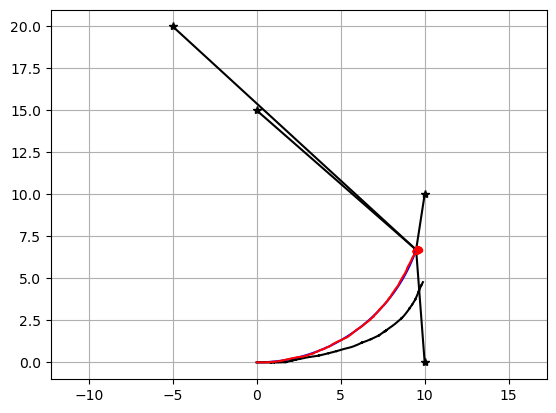

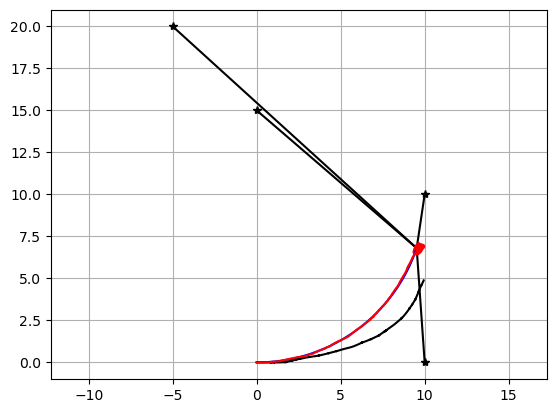

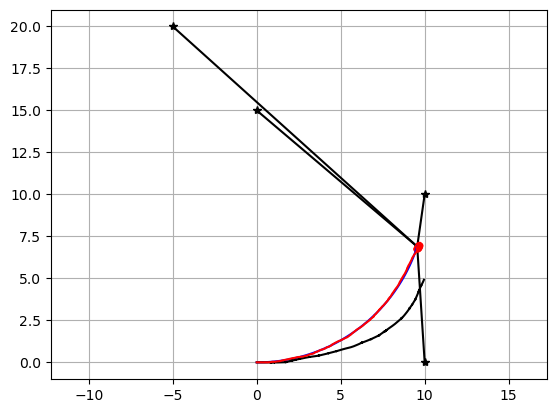

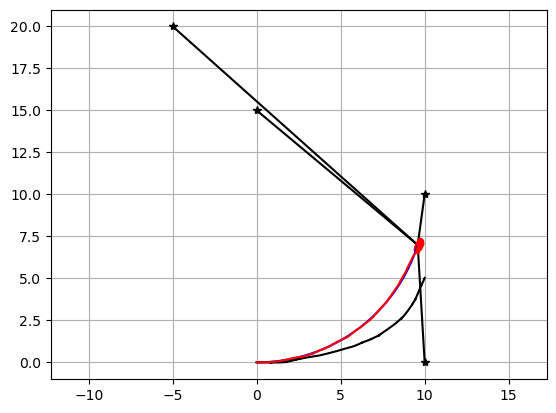

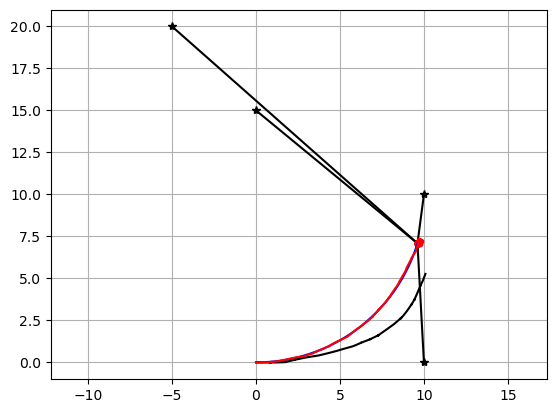

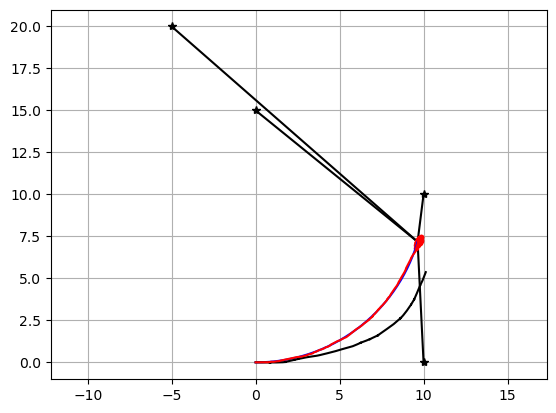

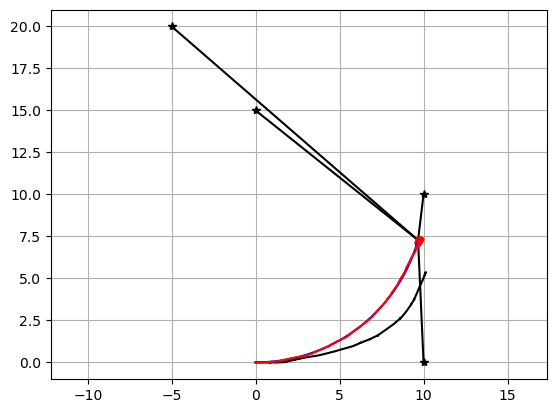

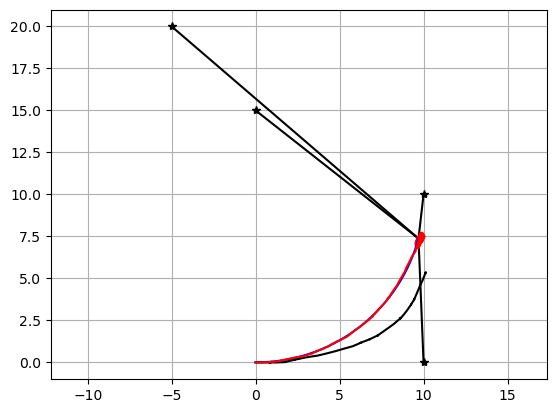

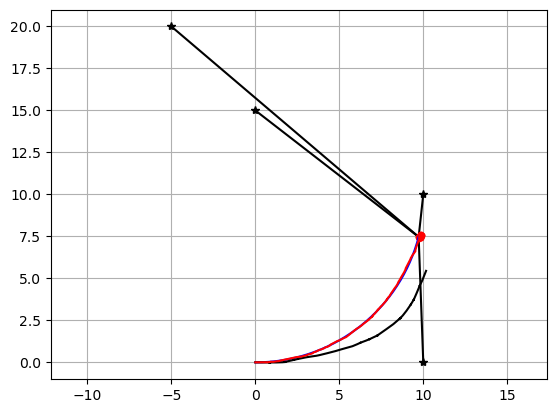

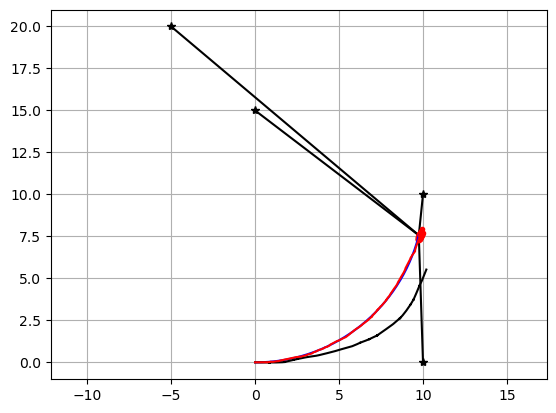

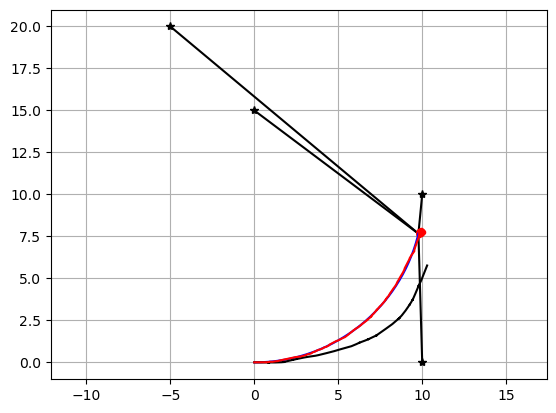

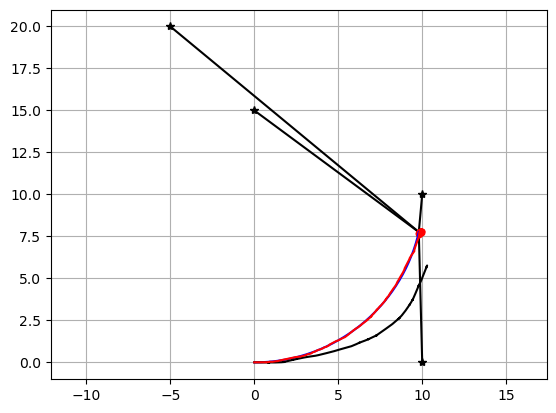

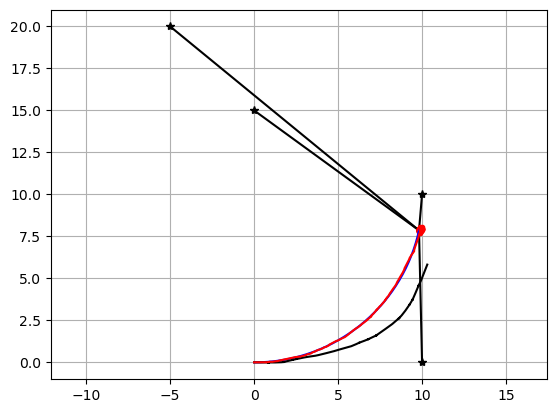

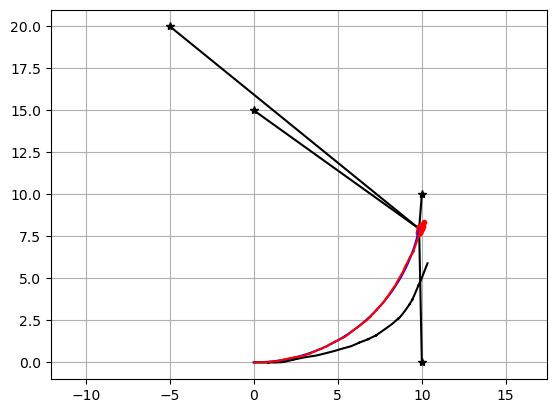

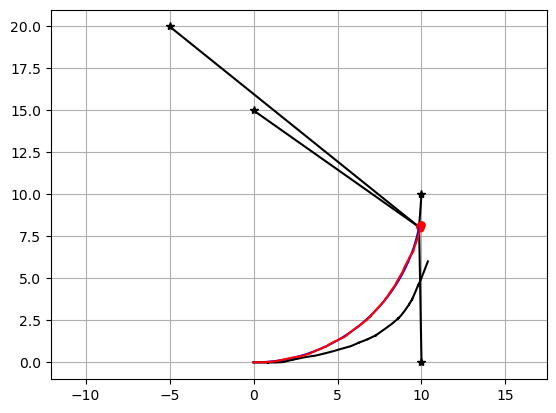

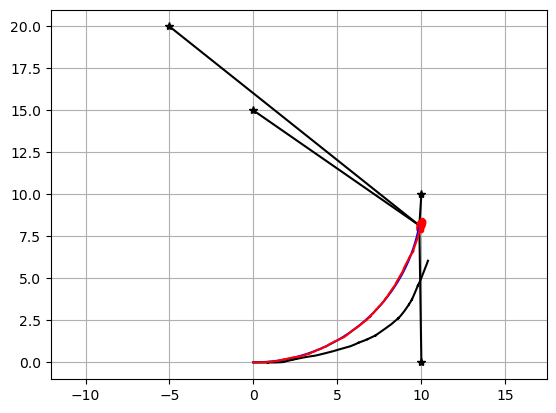

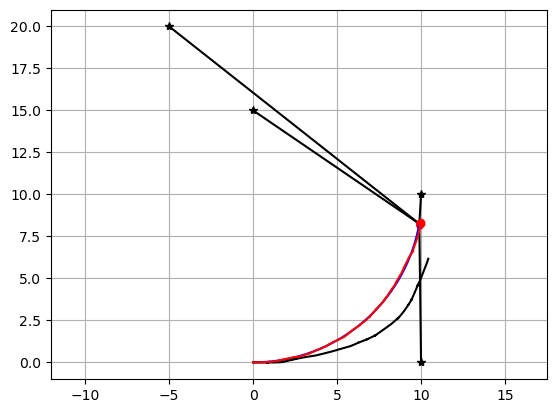

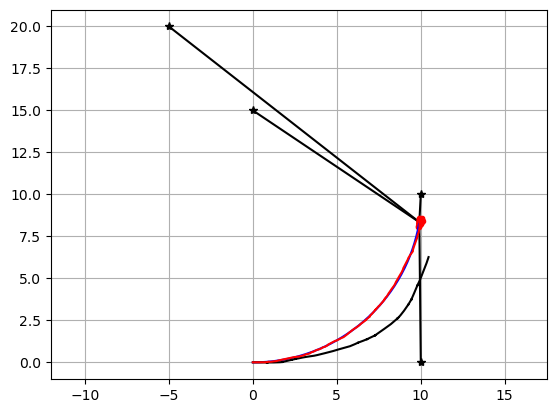

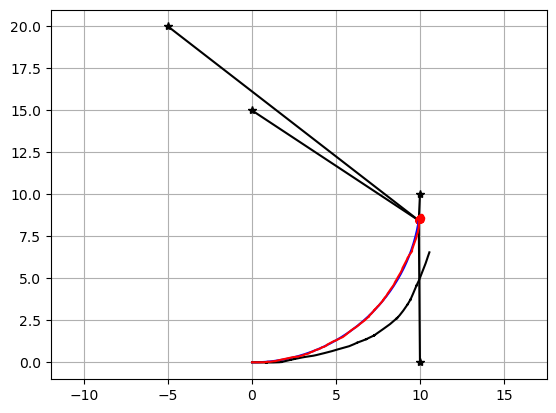

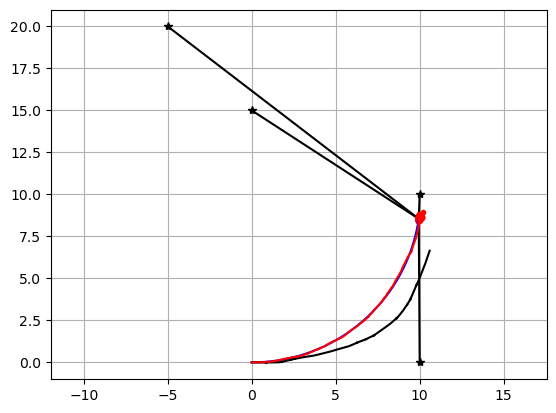

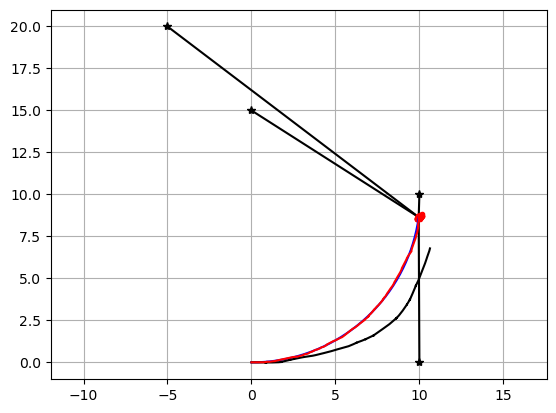

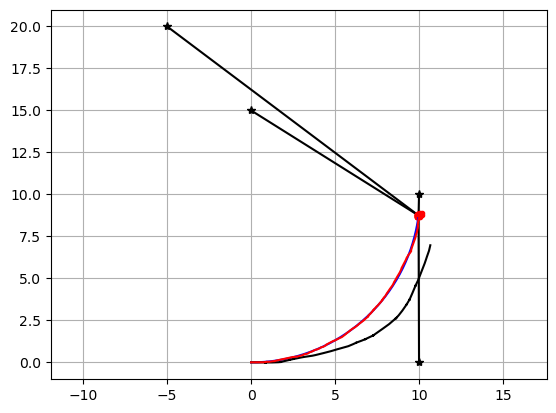

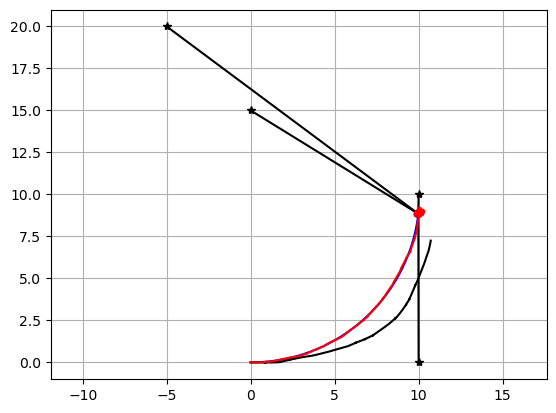

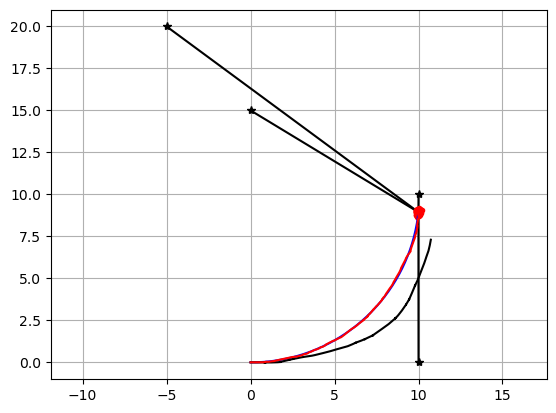

KeyboardInterrupt: 

In [9]:
if __name__ == '__main__':
    main()